In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# In order to save some MB of file I delated part of downloading images and saved models 
# /kaggle/input/models/effnet_b4_no_aug (1).pth
# /kaggle/input/models/resnet_binary.pth
# /kaggle/input/models/resnet_exp_lower_lr.pth
# /kaggle/input/models/vgg16_augmented.pth
# /kaggle/input/models/best_model (1).pth
# /kaggle/input/models/vgg16_no_aug.pth
# /kaggle/input/models/effnet_augmented.pth
# /kaggle/input/models/resnet_augmented.pth
# /kaggle/input/models/resnet_exp.pth
# /kaggle/input/models/resnet_no_aug (2).pth 

Alzheimer’s disease (AD) is a progressive neurodegenerative disorder that significantly impacts millions of individuals worldwide. Early and accurate diagnosis is crucial for managing the disease and improving patient outcomes. In this project, I explore the use of deep learning models for Alzheimer’s detection based on MRI scans, leveraging convolutional neural networks (CNNs) to classify brain images.

This study follows a structured engineering approach to evaluate model performance under different conditions, ensuring a reliable and reproducible methodology. The key objectives of this project include:

1. Training and Evaluating Three CNN Architectures
- I train ResNet50, VGG16, and EfficientNetB4 on the dataset, ensuring a strict patient-level split so that MRI scans from the same patient do not appear in both the training and test sets.
- Models are first trained on raw data (without augmentation) and later on augmented data to assess the impact of data preprocessing on classification performance.

2. Investigating the Impact of Data Leakage
- To demonstrate the importance of proper data partitioning, I conduct an experiment where the dataset is not split at the patient level, allowing images from the same patient to appear in both training and validation sets.
- This experiment aims to highlight how data leakage can artificially inflate model performance, leading to misleading conclusions in medical deep learning applications.

3. Binary vs. Multi-Class Classification
- Initially, the models perform four-class classification, distinguishing between Non-Demented, Very Mild Dementia, Mild Dementia, and Moderate Dementia.
- To analyze the impact of class granularity, I conduct a second experiment where I convert the dataset into a binary classification problem (Alzheimer vs. No Alzheimer). This simplifies the task and allows for comparison between multi-class and binary classification performance.

4. Project Goals
This project aims to provide valuable insights into the challenges and best practices for MRI-based Alzheimer’s detection using deep learning, addressing key questions such as:
- How do different CNN architectures perform in Alzheimer’s classification?
- What is the effect of data augmentation on model accuracy?
- How does improper data splitting impact performance, and why is patient-level separation crucial?
- Does binary classification lead to better generalization compared to a four-class approach?

By systematically exploring these factors, this project contributes to the development of more reliable and clinically relevant deep learning models for neurodegenerative disease diagnosis.

In [2]:
!pip install torchcam
# Library for generating CAMs if needed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00


In [3]:
!pip install torchmetrics

In [4]:
!pip install early-stopping-pytorch
# For Early stopping

In [5]:
# Tools and nessesaty packegaes 
import os 
import re 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import v2 
import torch
from torch.utils.data import DataLoader
import random
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score,MulticlassPrecision,MulticlassRecall,MulticlassAUROC
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryPrecision, BinaryRecall, BinaryAUROC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchsummary import summary
import torch.optim as optim 
from early_stopping_pytorch import EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_recall_curve, average_precision_score
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from sklearn.model_selection import train_test_split




# Models 
model_path_resnet_no_aug = '/kaggle/input/models/resnet_no_aug (2).pth'
model_path_vgg16_no_aug = '/kaggle/input/models/vgg16_no_aug.pth'
model_path_effnet_no_aug = '/kaggle/input/models/effnet_b4_no_aug (1).pth'

model_path_resnet_augment = '/kaggle/input/models/resnet_augmented.pth'
model_path_vgg16_augment = '/kaggle/input/models/vgg16_augmented.pth'
model_path_effnet_augment = '/kaggle/input/models/effnet_augmented.pth'

# experiments
model_path_resnet_binary = '/kaggle/input/models/resnet_binary.pth'
model_path_resnet_exp_lr_5 = '/kaggle/input/models/resnet_exp.pth'
model_path_resnet_exp_lr_4 = '/kaggle/input/models/resnet_exp_lower_lr.pth'



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
base_directory = "/kaggle/input/imagesoasis/Data"

classes = os.listdir(base_directory)

data = []
for class_label in classes:
    class_path = os.path.join(base_directory, class_label)
    for file_name in os.listdir(class_path):
        if file_name.endswith('.jpg'): 
            
            match = re.search(r'OAS1_(\d+)_', file_name)
            patient_id = match.group(1) if match else None
            if patient_id:  
                data.append({
                    "file_path": os.path.join(class_path, file_name),
                    "class": class_label,
                    "patient_id": int(patient_id)
                })

df = pd.DataFrame(data)

In [7]:
df

,file_path,class,patient_id
0,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,302
1,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,114
2,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,150
3,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,253
4,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,349
...,...,...,...
86432,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,28
86433,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,268
86434,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,137
86435,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,31


In [8]:
print(f"Number of MRI scans: {len(df)}")

Number of MRI scans: 86437


In [9]:
# Grouby petient_id and class
patient_class_counts = df.groupby('patient_id')['class'].nunique()

duplicate_patients = patient_class_counts[patient_class_counts > 1]

print(f"Number of patiences that are in more than one class: {len(duplicate_patients)}")
print(duplicate_patients)


Number of patiences that are in more than one class: 0
Series([], Name: class, dtype: int64)


As we can see `patient_id` are unique. There is no situation where one patient is in two or more classes

In [10]:
df["patient_id"].nunique()

347

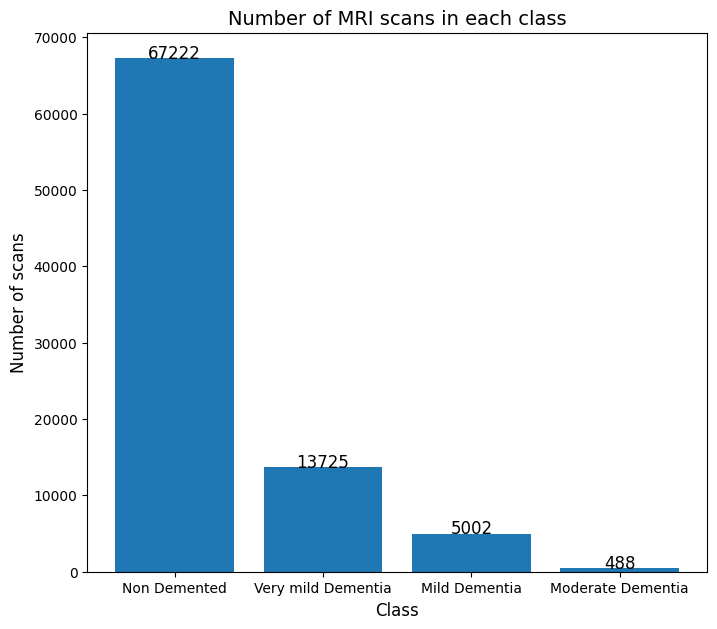

In [11]:
classes = df["class"].value_counts().index  
number_of_mris = df["class"].value_counts().values 

plt.figure(figsize=(8,7))
plt.bar(classes, number_of_mris)  
plt.title('Number of MRI scans in each class', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of scans', fontsize=12)

for i, value in enumerate(number_of_mris):  
    plt.text(i, value + 1, str(value), ha='center', fontsize=12)

plt.show()


The dataset is highly imbalanced, with the `Non Demented` class dominating at 67,222 scans.
The `Very Mild Dementia` class has significantly fewer samples (13,725), followed by `Mild Dementia` (5,002).
The `Moderate Dementia` class is severely underrepresented, with only 488 scans, making it the most challenging to classify.

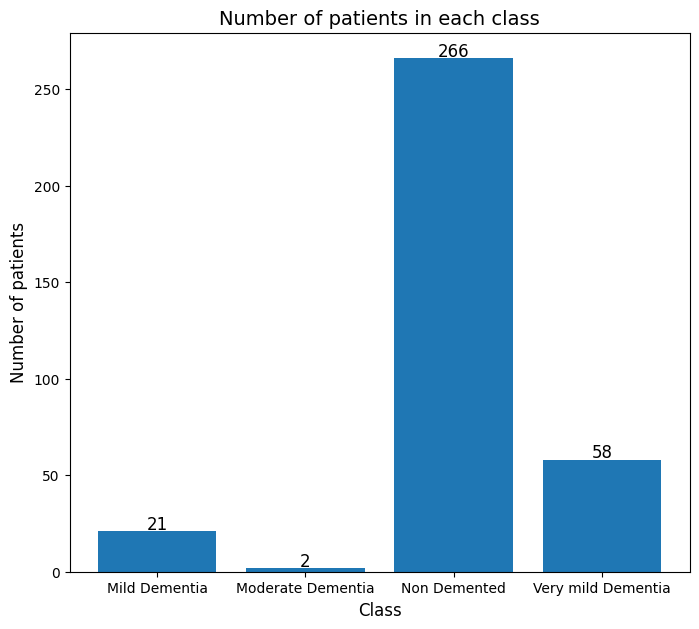

In [12]:
classes = df.groupby('class')['patient_id'].nunique().index
patient_counts = df.groupby('class')['patient_id'].nunique().values

plt.figure(figsize=(8, 7))
plt.bar(classes, patient_counts)
plt.title('Number of patients in each class', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of patients', fontsize=12)

for i, value in enumerate(patient_counts):
    plt.text(i, value + 1, str(value), ha='center', fontsize=12)

plt.show()


Based on the plot above, we see that the `Moderate Dementia` class contains only 2 patients. Therefore, we are unable to split the dataset into three sets—test, train, and validation - while ensuring that scans from the same patient do not appear across multiple splits.

In [13]:
duplicate_rows = df[df["file_path"].duplicated()]
print(f"Number of duplicate rows: {len(duplicate_rows)}")


Number of duplicate rows: 0


In [14]:
from collections import Counter
file_paths = df['file_path']
duplicates = [item for item, count in Counter(file_paths).items() if count > 1]
print(f"Duplicated file paths: {len(duplicates)}")


Duplicated file paths: 0


# Dataset 

In [15]:
mild_dementia_df = df[df['class'] == 'Mild Dementia']
moderate_dementia_df = df[df['class'] == 'Moderate Dementia']
non_demented_df = df[df['class'] == 'Non Demented']
very_mild_dementia_df = df[df['class'] == 'Very mild Dementia']

In [16]:
mild_dementia_df

,file_path,class,patient_id
81435,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,185
81436,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,269
81437,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,316
81438,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,53
81439,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,382
...,...,...,...
86432,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,28
86433,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,268
86434,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,137
86435,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,31


In [17]:
moderate_dementia_df

,file_path,class,patient_id
80947,/kaggle/input/imagesoasis/Data/Moderate Dement...,Moderate Dementia,351
80948,/kaggle/input/imagesoasis/Data/Moderate Dement...,Moderate Dementia,351
80949,/kaggle/input/imagesoasis/Data/Moderate Dement...,Moderate Dementia,308
80950,/kaggle/input/imagesoasis/Data/Moderate Dement...,Moderate Dementia,308
80951,/kaggle/input/imagesoasis/Data/Moderate Dement...,Moderate Dementia,308
...,...,...,...
81430,/kaggle/input/imagesoasis/Data/Moderate Dement...,Moderate Dementia,308
81431,/kaggle/input/imagesoasis/Data/Moderate Dement...,Moderate Dementia,308
81432,/kaggle/input/imagesoasis/Data/Moderate Dement...,Moderate Dementia,351
81433,/kaggle/input/imagesoasis/Data/Moderate Dement...,Moderate Dementia,351


In [18]:
non_demented_df

,file_path,class,patient_id
0,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,302
1,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,114
2,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,150
3,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,253
4,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,349
...,...,...,...
67217,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,186
67218,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,2
67219,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,83
67220,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,148


Initially, I considered an approach where I would select a patient with the lowest number of scans and exclude them from the training and validation sets to evaluate the model’s generalization on an entirely unseen patient. This method was intended to be applied to the most numerous class, `Non Demented`, to minimize the impact of class imbalance. However, after further analysis, this approach was not implemented, as the primary focus remained on maintaining a strict patient-level split across the dataset and not to apply CAMs

In [19]:
non_demented_df["patient_id"].value_counts()

patient_id
156    488
101    488
239    488
236    488
111    488
      ... 
192    183
126    183
188    183
29     122
7      122
Name: count, Length: 266, dtype: int64

I will pick patient number 7, because he/she has the smallest number of scans.

### One patient left on purpuse

In [20]:
patient_to_gen_cams_and_test_model = non_demented_df[non_demented_df["patient_id"]==7]
patient_to_gen_cams_and_test_model

,file_path,class,patient_id
1618,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,7
2593,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,7
3222,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,7
3365,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,7
3399,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,7
...,...,...,...
65234,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,7
65597,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,7
66365,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,7
66706,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,7


In [21]:
non_demented_df = non_demented_df[non_demented_df['patient_id'] != 7]


In [22]:
print(f"Removed patient 7 data: {len(patient_to_gen_cams_and_test_model)} rows")
print(f"Updated DataFrame size after removal: {len(non_demented_df)} rows")

Removed patient 7 data: 122 rows
Updated DataFrame size after removal: 67100 rows


In [23]:
non_demented_df

,file_path,class,patient_id
0,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,302
1,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,114
2,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,150
3,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,253
4,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,349
...,...,...,...
67217,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,186
67218,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,2
67219,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,83
67220,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,148


In [24]:
very_mild_dementia_df

,file_path,class,patient_id
67222,/kaggle/input/imagesoasis/Data/Very mild Demen...,Very mild Dementia,82
67223,/kaggle/input/imagesoasis/Data/Very mild Demen...,Very mild Dementia,16
67224,/kaggle/input/imagesoasis/Data/Very mild Demen...,Very mild Dementia,161
67225,/kaggle/input/imagesoasis/Data/Very mild Demen...,Very mild Dementia,290
67226,/kaggle/input/imagesoasis/Data/Very mild Demen...,Very mild Dementia,247
...,...,...,...
80942,/kaggle/input/imagesoasis/Data/Very mild Demen...,Very mild Dementia,243
80943,/kaggle/input/imagesoasis/Data/Very mild Demen...,Very mild Dementia,362
80944,/kaggle/input/imagesoasis/Data/Very mild Demen...,Very mild Dementia,3
80945,/kaggle/input/imagesoasis/Data/Very mild Demen...,Very mild Dementia,288


In [25]:
very_mild_dementia_df["patient_id"].nunique()

58

In [26]:
len(mild_dementia_df) + len(moderate_dementia_df) + len(non_demented_df) + len(very_mild_dementia_df) , len(df)

(86315, 86437)

Because of the lack of enough patients in the `Moderate Dementia` class, I am forced not to split the data into three parts (train, validation, and test) as is normally done. Instead, to ensure that scans from the same patient appear in only one split, I will create train and validation splits using `GroupShuffleSplit`.

In [27]:
def split_data(dataframe, test_size=0.2, random_state=42):
    """
    Splits the dataframe into training and testing sets while ensuring that 
    all rows for a given `patient_id` stay in the same set. 
    
    Parameters:
    - dataframe: pandas.DataFrame containing the data with a `patient_id` column.
    - test_size: float (default=0.2), proportion of data in the test set.
    - random_state: int (default=42), for reproducibility of the split.
    
    Returns:
    - train_df: Training set as a DataFrame.
    - test_df: Testing set as a DataFrame.
    """
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(splitter.split(dataframe, groups=dataframe['patient_id']))
    train_df = dataframe.iloc[train_idx]
    test_df = dataframe.iloc[test_idx]
    return train_df, test_df


def check_patient_id_overlap(train_df, test_df):
    """
    Checks whether the same patient_id exists in both the training and testing datasets.

    Parameters:
    - train_df: DataFrame containing the training dataset.
    - test_df: DataFrame containing the testing dataset.

    Returns:
    - None, but prints information about overlapping patient_ids.
    """
    # Get unique patient IDs from both datasets
    train_patient_ids = set(train_df['patient_id'].unique())
    test_patient_ids = set(test_df['patient_id'].unique())
    
    # Find the intersection of patient IDs between the datasets
    overlapping_ids = train_patient_ids.intersection(test_patient_ids)
    
    if overlapping_ids:
        print(f"Found {len(overlapping_ids)} overlapping patient_id(s):")
        print(overlapping_ids)
    else:
        print("No overlapping patient_ids between the training and testing datasets.")





In [28]:
# Devide each class separately
mild_train, mild_test = split_data(mild_dementia_df)
moderate_train, moderate_test = split_data(moderate_dementia_df)
non_train, non_test = split_data(non_demented_df)
very_mild_train, very_mild_test = split_data(very_mild_dementia_df)

# Combine Dataframes
train_data = pd.concat([mild_train, moderate_train, non_train, very_mild_train]).reset_index(drop=True)
test_data = pd.concat([mild_test, moderate_test, non_test, very_mild_test]).reset_index(drop=True)


print(f"Training: {len(train_data)}")
print(f"Test: {len(test_data)}")


Training: 68381
Test: 17934


In [29]:
check_patient_id_overlap(train_data,test_data)

No overlapping patient_ids between the training and testing datasets.


## Custom Dataset

In [30]:

class AlzheimerDataset(Dataset):
    def __init__(self, dataframe, transform=None, return_path=False):
        
        self.dataframe = dataframe
        self.transform = transform
        self.return_path = return_path  # Addnig option to return file_path, gives easier aceces to images later
        self.class_mapping = {"Mild Dementia": 0, "Moderate Dementia": 1, "Non Demented": 2, "Very mild Dementia": 3}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        file_path = self.dataframe.iloc[idx]['file_path']
        label = self.class_mapping[self.dataframe.iloc[idx]['class']]
        image = Image.open(file_path).convert("RGB") # Creating 3 channels - prepae for ResNET and other pretrained model's architecture
        if self.transform:
            image = self.transform(image)

        if self.return_path:  # Passibility of getting file_path
            return image, label, file_path
        return image, label

## Image Preprocessing


In [31]:
train_transform_no_augmentation = v2.Compose([
    v2.ToImage(), 
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # prepare for ResNet50 , VGG16, normalize 3 channels
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((224,224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Datasets function

In [32]:
def create_data_sets(train_data, test_data, train_transf, test_transf):
    train_dataset = AlzheimerDataset(train_data, transform=train_transf,return_path=False)
    test_dataset = AlzheimerDataset(test_data, transform=test_transform,return_path=True)
    return train_dataset, test_dataset

def create_data_loaders(train_data_set, test_data_set, batch):
    train_loader = DataLoader(train_data_set,batch, shuffle=True,num_workers=2)
    test_loader = DataLoader(test_data_set, batch, shuffle=False,num_workers=2)
    return train_loader, test_loader

In [33]:
# Datasets without any augmentations
train_dataset_no_aug , test_dataset = create_data_sets(train_data, test_data, train_transform_no_augmentation, test_transform)

# DataLoaders
train_loader_no_aug, test_loader = create_data_loaders(train_dataset_no_aug,test_dataset,32)


## Functions to plot results and metrics

In [34]:
# Metrics, we are using macro becuase dataset is unbalanced
accuracy = MulticlassAccuracy(num_classes=4, average="macro").to(device)
f1 = MulticlassF1Score(num_classes=4, average="macro").to(device)
precision = MulticlassPrecision(num_classes=4, average="macro").to(device)
recall = MulticlassRecall(num_classes=4, average="macro").to(device)
auc_metric = MulticlassAUROC(num_classes=4, average="macro").to(device)

# Validation metrics
val_accuracy = MulticlassAccuracy(num_classes=4, average="macro").to(device)
val_f1 = MulticlassF1Score(num_classes=4, average="macro").to(device)
val_precision = MulticlassPrecision(num_classes=4, average="macro").to(device)
val_recall = MulticlassRecall(num_classes=4, average="macro").to(device)
val_auc_metric = MulticlassAUROC(num_classes=4, average="macro").to(device)

In [35]:
def plot_loss(epochs, train_loss, test_loss):
    """
    Plots the training and validation/test loss across epochs.

    Parameters:
    - epochs: List or range of epoch numbers.
    - train_loss: List of training loss values per epoch.
    - test_loss: List of validation/test loss values per epoch.

    Displays a line plot comparing training and validation/test loss over time.
    """
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, test_loss, label="Validation/Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss per Epoch")
    plt.legend()
    plt.show()


In [36]:
def plot_accuracy(epochs, train_acc, test_acc):
    """
    Plots the training and validation/test accuracy across epochs.

    Parameters:
    - epochs: List or range of epoch numbers.
    - train_acc: List of training accuracy values per epoch.
    - test_acc: List of validation/test accuracy values per epoch.

    Displays a line plot comparing training and validation/test accuracy over time.
    """
    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, test_acc, label="Validation/Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Epoch")
    plt.legend()
    plt.show()


In [37]:
def plot_roc_curve(y_true, y_probs, num_classes=4):
    """
    Plots the ROC curve for a multi-class classification problem.

    Parameters:
    - y_true: List of true labels.
    - y_probs: List of predicted probabilities for each class.
    - num_classes: Number of classes (default is 4).

    Generates one-vs-rest ROC curves for each class, calculates the AUC, and displays a plot comparing ROC curves for all classes.
    """
    
    fpr = {}  
    tpr = {} 
    roc_auc = {}  

    
    for i in range(num_classes):
        #  one-vs-rest
        y_true_binary = [1 if label == i else 0 for label in y_true]
        y_probs_class = [prob[i] for prob in y_probs]

        
        fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_probs_class) 
        roc_auc[i] = auc(fpr[i], tpr[i])

    # ROC plot for each class
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Random guess line
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()




In [38]:
class_names = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]
def plot_confusion_matrix(y_true, y_pred, class_names,figsize=(8, 9.5)):
    """
    Plots the confusion matrix for a multi-class classification problem.

    Parameters:
    - y_true: List of true labels.
    - y_pred: List of predicted labels.
    - class_names: List of class names for labeling the matrix.
    - figsize: Tuple specifying the figure size (default is (8, 9.5)).

    Displays a confusion matrix with labeled axes and a color-coded heatmap.
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title("Confusion Matrix")
    plt.show()

In [39]:
def plot_precision_recall_curve(y_true, y_probs, num_classes=4):
    """
    Plot Precision-Recall Curve for a multi-class classification problem in a One-vs-Rest (OvR) setting.

    Parameters:
    ----------
    y_true : list or array
        Ground truth (true labels) for the dataset. Each element corresponds to the actual class of the data instance.
    
    y_probs : list or array
        Predicted probabilities for each class. Each element is a list of probabilities for all classes (e.g., the output of softmax).
    
    num_classes : int, optional (default=4)
        Total number of classes in the classification problem. The function will plot the Precision-Recall Curve for each class.
     """

    plt.figure(figsize=(8, 6))

    for i in range(num_classes):
        y_true_binary = [1 if label == i else 0 for label in y_true]
        y_probs_class = [prob[i] for prob in y_probs]

        precision, recall, _ = precision_recall_curve(y_true_binary, y_probs_class)
        ap_score = average_precision_score(y_true_binary, y_probs_class)

        
        plt.plot(recall, precision, label=f'Class {i} (AP = {ap_score:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (One-vs-Rest)')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()


## Functions to save and load models

In [40]:
def save_model(model, model_results, model_y_true, model_y_pred, model_y_probs, model_name_to_save, file_path="/kaggle/working"):

    full_path = file_path + "/" + model_name_to_save
    torch.save({
        'model_state_dict': model.state_dict(),
        'results': model_results,
        'y_true': model_y_true,
        'y_pred': model_y_pred,
        'y_probs': model_y_probs
    }, full_path)
    print(f"Model and results saved to {full_path}.")




def open_saved_model(model_path, arch="resnet50", num_classes=4):

   
    checkpoint = torch.load(model_path, map_location=device, weights_only=True)


    if arch == "resnet50":
        model_instance = resnet50(weights=None)
        model_instance.fc = nn.Sequential(
            nn.Linear(model_instance.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )
    elif arch == "vgg16":
        model_instance = vgg16(weights=None)
        model_instance.classifier[6] = nn.Sequential(
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    elif arch == "efficientnet_b4":
        model_instance = efficientnet_b4(weights=None)
        in_features = model_instance.classifier[1].in_features
        model_instance.classifier[1] = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )    
    else:
        raise ValueError(f"Arch '{arch}' not supported in this function.")


    model_instance.to(device)
     
    model_instance.load_state_dict(checkpoint['model_state_dict'])

    model_results = checkpoint['results']
    model_y_true = checkpoint['y_true']
    model_y_pred = checkpoint['y_pred']
    model_y_probs = checkpoint['y_probs']

    print(f"Model ({arch}) and results loaded from {model_path}.")
    return model_instance, model_results, model_y_true, model_y_pred, model_y_probs


# Function to validate and train models

In [41]:
def train_with_validation(model, train_loader, loss_function, optimizer, epochs, val_loader=None):
    model.to(device)
    torch.manual_seed(42)
    
    scheduler = ReduceLROnPlateau(
        optimizer, 
        mode='max',           
        factor=0.1,           
        patience=3,           
        threshold=0.0001,     
        verbose=True
    )
    
    results = {
        "epochs": [],
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": [],
        "train_precision": [],
        "val_precision": [],
        "train_recall": [],
        "val_recall": [],
        "train_f1": [],
        "val_f1": [],
        "train_auc": [],
        "val_auc": [],
        "best_epoch_number": 0
    }

    best_val_f1 = float('-inf')
    best_y_true = []
    best_y_pred = []
    best_y_probs = []


    early_stopping = EarlyStopping(patience=5, verbose=True, path='best_model.pth',delta = 0.001) # Early stopping params, may change later

    
    for epoch in range(epochs):
        model.train()
        

        accuracy.reset()
        f1.reset()
        precision.reset()
        recall.reset()
        auc_metric.reset()

        train_loss_batch = 0

        if val_loader:
            val_accuracy.reset()
            val_f1.reset()
            val_precision.reset()
            val_recall.reset()
            val_auc_metric.reset()
            val_loss_batch = 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            preds = model(X)
            loss = loss_function(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_batch += loss.item()
            accuracy.update(preds, y)
            f1.update(preds, y)
            precision.update(preds, y)
            recall.update(preds, y)
            auc_metric.update(preds, y)

        train_loss = train_loss_batch / len(train_loader)
        train_acc = accuracy.compute().item()
        train_precision = precision.compute().item()
        train_recall = recall.compute().item()
        train_f1 = f1.compute().item()
        train_auc = auc_metric.compute().item()

        results["epochs"].append(epoch)
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_acc)
        results["train_precision"].append(train_precision)
        results["train_recall"].append(train_recall)
        results["train_f1"].append(train_f1)
        results["train_auc"].append(train_auc)


        # Validation
        y_true = []
        y_pred = []
        y_probs = []  # Probabilities
        
   
        if val_loader is not None:
            model.eval()
            with torch.inference_mode():
                for X_val, y_val , _ in val_loader:
                    X_val, y_val = X_val.to(device), y_val.to(device)
                    predictions = model(X_val)
                    val_loss = loss_function(predictions, y_val)
                    val_loss_batch += val_loss.item()

                    val_accuracy.update(predictions, y_val)
                    val_f1.update(predictions, y_val)
                    val_precision.update(predictions, y_val)
                    val_recall.update(predictions, y_val)
                    val_auc_metric.update(predictions, y_val)

                    y_true.extend(y_val.cpu().tolist())
                    y_pred.extend(predictions.argmax(dim=1).cpu().tolist())
                    y_probs.extend(torch.softmax(predictions, dim=1).cpu().tolist())
                     
                 

                val_loss = val_loss_batch / len(val_loader)
                val_acc = val_accuracy.compute().item()
                val_precision_ = val_precision.compute().item()
                val_recall_ = val_recall.compute().item()
                val_f1_ = val_f1.compute().item()
                val_auc_ = val_auc_metric.compute().item()

                results["val_loss"].append(val_loss)
                results["val_accuracy"].append(val_acc)
                results["val_precision"].append(val_precision_)
                results["val_recall"].append(val_recall_)
                results["val_f1"].append(val_f1_)
                results["val_auc"].append(val_auc_)

                scheduler.step(val_f1_) # Learing rate adjustement

                # Save results of best model
                if val_f1_ > best_val_f1:
                    best_val_f1 = val_f1_
                    best_y_true = y_true.copy()
                    best_y_pred = y_pred.copy()
                    best_y_probs = y_probs.copy()
                    results["best_epoch_number"] = epoch

                early_stopping(-val_f1_,model) # This function is written in the way that minimizing is better, but in my case i want to maximzie this value. Thas why i use '-' sign
                if early_stopping.early_stop:                  #https://github.com/Bjarten/early-stopping-pytorch/blob/main/early_stopping_pytorch/early_stopping.py#L28
                    print("Early stopping triggered!")
                    break
        
        if epoch % 2 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}/{epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train AUC: {train_auc:.4f}")
            if  val_loader is not None:
                print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1: {val_f1_:.4f}, Val Precision: {val_precision_:.4f}, Val Recall: {val_recall_:.4f}, Val AUC: {val_auc_:.4f}")
    

    

    
    print("Loading the best model...")
    
    model.load_state_dict(torch.load('best_model.pth', weights_only=True))
   
    

    return model, results, best_y_true, best_y_pred, best_y_probs



# Models

## ResNET 50 

In [42]:
def initialize_resnet50(num_classes=4):
    model = resnet50(weights=ResNet50_Weights.DEFAULT)

    for param in model.parameters():
        param.requires_grad = False
    
 
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),  
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(512, num_classes)  
    ) 
    
    for param in model.fc.parameters():
            param.requires_grad = True
         
    return model.to(device)

resnet_no_aug = initialize_resnet50()

resnet_no_aug_loss = nn.CrossEntropyLoss()
resnet_no_aug_loss_optim = optim.Adam(resnet_no_aug.fc.parameters(), lr=1e-5)  


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s]


In [43]:
summary(resnet_no_aug, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## VGG16

In [44]:
def initialize_vgg16(num_classes=4):
 
    model = vgg16(weights=VGG16_Weights.DEFAULT)

    for param in model.features.parameters():
        param.requires_grad = False


    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Sequential(
        nn.Linear(in_features, 512), 
        nn.ReLU(),            
        nn.Dropout(0.5),      
        nn.Linear(512, num_classes) 
    )

    
    for param in model.classifier.parameters():
        param.requires_grad = True

    return model.to(device)

vgg16_no_aug = initialize_vgg16()

vgg16_no_aug_loss = nn.CrossEntropyLoss()
vgg16_no_aug_optim = optim.Adam(vgg16_no_aug.parameters(), lr=1e-5)  


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 176MB/s]


In [45]:
summary(vgg16_no_aug, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## EfficientNet-B4
Since `EfficientNet` requires different input size, it is mandatory to change preprocessing step.   

In [46]:
train_transform_no_augmentation_effnetB4 = v2.Compose([
    v2.ToImage(), 
    v2.Resize((380, 380)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform_effnetB4 = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((380, 380), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])





In [47]:
# Datasets for EfficientNet-B4 without any augmentations
train_dataset_no_aug_effnetB4 , test_dataset_effnetB4 = create_data_sets(train_data, test_data, train_transform_no_augmentation_effnetB4, test_transform_effnetB4)

# DataLoaders
train_loader_no_aug_effnetB4, test_loader_effnetB4 = create_data_loaders(train_dataset_no_aug_effnetB4,test_dataset_effnetB4,32)

In [48]:
def initialize_efficientnet_b4(num_classes=4):

    model = efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)

    for param in model.parameters():
        param.requires_grad = False

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Sequential(
        nn.Linear(in_features, 512),  
        nn.ReLU(),                   
        nn.Dropout(0.5),             
        nn.Linear(512, num_classes)  
    )

    for param in model.classifier[1].parameters():
        param.requires_grad = True

    return model.to(device)


effnet_b4_no_aug = initialize_efficientnet_b4()

effnet_b4_no_aug_loss = nn.CrossEntropyLoss()
effnet_b4_no_aug_optim = optim.Adam(effnet_b4_no_aug.parameters(), lr=1e-5)  



Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 196MB/s]


In [49]:
summary(effnet_b4_no_aug, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 112, 112]           1,296
       BatchNorm2d-2         [-1, 48, 112, 112]              96
              SiLU-3         [-1, 48, 112, 112]               0
            Conv2d-4         [-1, 48, 112, 112]             432
       BatchNorm2d-5         [-1, 48, 112, 112]              96
              SiLU-6         [-1, 48, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8             [-1, 12, 1, 1]             588
              SiLU-9             [-1, 12, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             624
          Sigmoid-11             [-1, 48, 1, 1]               0
SqueezeExcitation-12         [-1, 48, 112, 112]               0
           Conv2d-13         [-1, 24, 112, 112]           1,152
      BatchNorm2d-14         [-1, 24, 1

# Training models without augmentation

## Model 1 -  ResNET50

In [50]:
# resnet_no_aug_trained, resnet_no_aug_results, resnet_no_aug_y_true, resnet_no_aug_y_pred, resnet_no_aug_y_probs = train_with_validation(resnet_no_aug, train_loader_no_aug, 
#                                                                                                                                         resnet_no_aug_loss, resnet_no_aug_loss_optim, 35, test_loader) 


In [51]:
# save_model(resnet_no_aug_trained, resnet_no_aug_results, resnet_no_aug_y_true, resnet_no_aug_y_pred, resnet_no_aug_y_probs,"resnet_no_aug.pth")

In [52]:
resnet_no_aug_loaded, resnet_no_aug_loaded_results, resnet_no_aug_loaded_y_true, resnet_no_aug_loaded_y_pred,  resnet_no_aug_loaded_y_probs = open_saved_model(model_path_resnet_no_aug, arch="resnet50")

Model (resnet50) and results loaded from /kaggle/input/models/resnet_no_aug (2).pth.


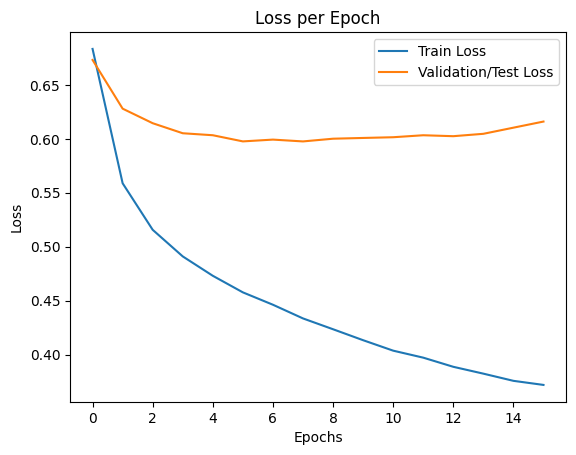

In [53]:
plot_loss(resnet_no_aug_loaded_results["epochs"], resnet_no_aug_loaded_results["train_loss"], resnet_no_aug_loaded_results["val_loss"])

This graph illustrates the "Loss per Epoch" for both training and validation/test sets during the training process of a model. Key observations include:

1. Training Loss:
- The training loss decreases steadily across epochs, indicating that the model is learning effectively from the training data.

2. Validation/Test Loss:
- The validation/test loss decreases initially but stabilizes and starts to slightly increase after around epoch 10.
This suggests potential overfitting, as the model begins to perform less well on unseen data while continuing to improve on the training set.

3. General Trend:
- Both curves exhibit a similar downward trend at the start, reflecting proper optimization during the initial epochs.
The divergence between training and validation/test loss curves in later epochs highlights the need for regularization techniques, early stopping, or tuning the model to prevent overfitting.

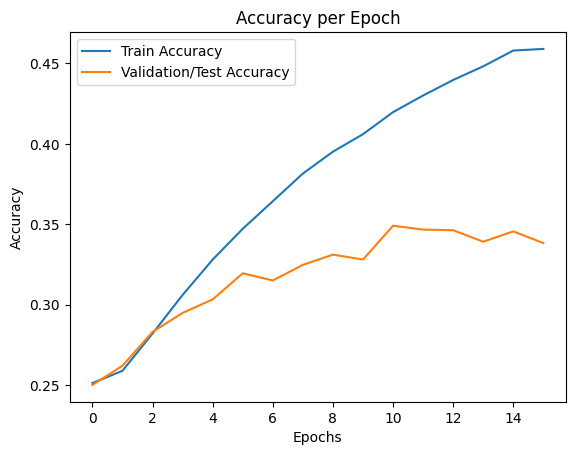

In [54]:
plot_accuracy(resnet_no_aug_loaded_results["epochs"], resnet_no_aug_loaded_results["train_accuracy"], resnet_no_aug_loaded_results["val_accuracy"])

The "Accuracy per Epoch" plot provides an overview of the model's performance during training and validation. Key insights from this graph include:

1. Training Accuracy:
- The training accuracy steadily increases across epochs, indicating that the model is successfully learning from the training data.
- By the end of the training process, the model achieves a higher accuracy of approximately 0.45, reflecting its capability to correctly classify a significant portion of the training data.

2. Validation/Test Accuracy:
- The validation/test accuracy improves during the initial epochs, peaking around epoch 8–10. However, it begins to fluctuate slightly afterward, suggesting a plateau in the model's generalization performance.
- The gap between training and validation/test accuracy becomes more evident after epoch 10, hinting at potential overfitting.

3. Overall Trend:
- The divergence between the training and validation/test accuracy curves emphasizes that while the model is becoming increasingly effective on the training set, its ability to generalize to unseen data is limited.
- The lack of sustained improvement in validation accuracy after epoch 10 suggests the need for optimization strategies such as regularization, early stopping, or fine-tuning hyperparameters to enhance generalization.

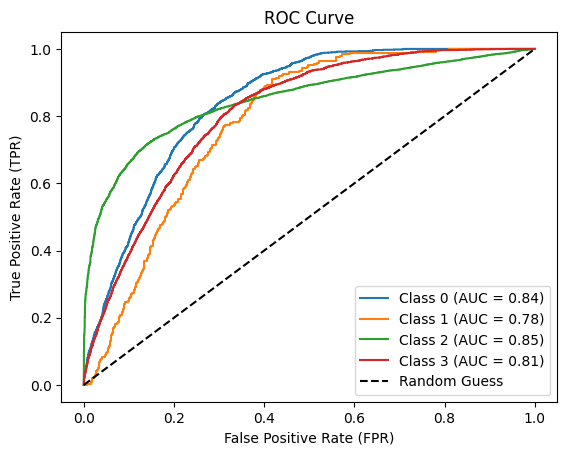

In [55]:
plot_roc_curve(resnet_no_aug_loaded_y_true,resnet_no_aug_loaded_y_probs)

The ROC Curve illustrates the performance of the multi-class classification model for Alzheimer's disease across four classes, with the Area Under the Curve (AUC) metric used to evaluate its effectiveness. Key observations include:

1. Class-Specific Performance:

- Class 0 (AUC = 0.84): This class shows strong discriminatory power, indicating a high ability to distinguish it from other classes.
- Class 1 (AUC = 0.78): This class has the lowest AUC, suggesting the model struggles slightly more to differentiate this class from others.
- Class 2 (AUC = 0.85): The highest AUC value, showing excellent performance in identifying this class.
- Class 3 (AUC = 0.81): Moderately strong performance, though slightly lower than Class 0 and Class 2.

2. General Trends:

- All classes demonstrate AUC values above 0.75, reflecting reasonable model performance in distinguishing different stages of Alzheimer's disease.
- The curves deviate significantly from the random guess line (AUC = 0.5), indicating the model's capability to provide meaningful predictions.

3. Implications for Multi-Class Classification:

- The variability in AUC across classes suggests that the model's performance is not uniform. It is more effective at distinguishing certain stages of Alzheimer's disease (e.g., Class 2 and Class 0) compared to others (e.g., Class 1).
- Further model fine-tuning or data augmentation strategies might be necessary to improve the classification for underperforming classes, particularly Class 1.

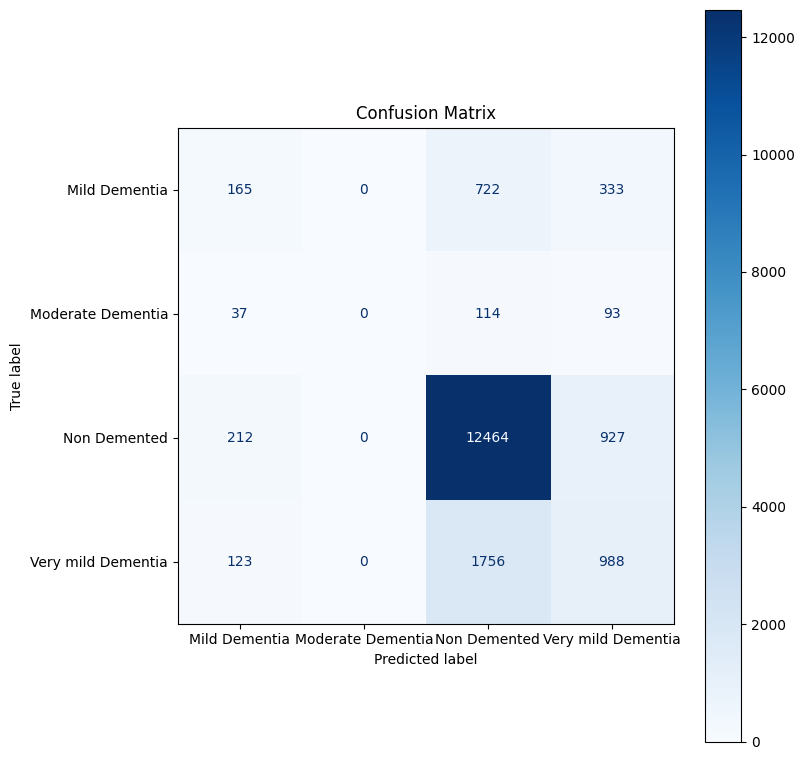

In [56]:
plot_confusion_matrix(resnet_no_aug_loaded_y_true,resnet_no_aug_loaded_y_pred,class_names)

The confusion matrix provides a detailed evaluation of the model's performance for the multi-class classification task of Alzheimer's disease stages. Key insights include:

1. Dominance of "Non-Demented" Predictions:

- The model performs best for the Non-Demented class, with 12,464 correctly classified samples. This indicates that the model has a strong ability to identify non-demented patients, as shown by the highest diagonal value.
- However, there is some misclassification of non-demented patients as Very Mild Dementia (927 samples), suggesting overlap between these classes.

2. Performance for Other Classes:
- Mild Dementia: Out of all true Mild Dementia cases, the model correctly predicts only 165, with significant misclassifications as Very Mild Dementia (333) and Non-Demented (722). This highlights challenges in distinguishing Mild Dementia from neighboring stages.
- Moderate Dementia: 0 samples are correctly classified, and number of misclassifications as Very Mild Dementia (37) and Non-Demented (114) and Very Mild Dementia (93). This indicates  difficulty in identifying this class.
- Very Mild Dementia: The model correctly classifies 988 samples but misclassifies many as Non-Demented (1,756), reflecting high confusion between these two classes.

3. Challenges in Classification:

- The confusion matrix reveals that the model struggles to differentiate between adjacent stages of dementia (e.g., Mild Dementia and Very Mild Dementia, as well as Non-Demented and Very Mild Dementia). This is a common issue in medical datasets where stages of a disease often share overlapping features.

4. Imbalance in Class Predictions:

- The matrix suggests that the model is biased towards predicting the Non-Demented class, which could be due to class imbalance in the dataset. Classes such as Mild Dementia and Moderate Dementia are underrepresented in correct predictions.

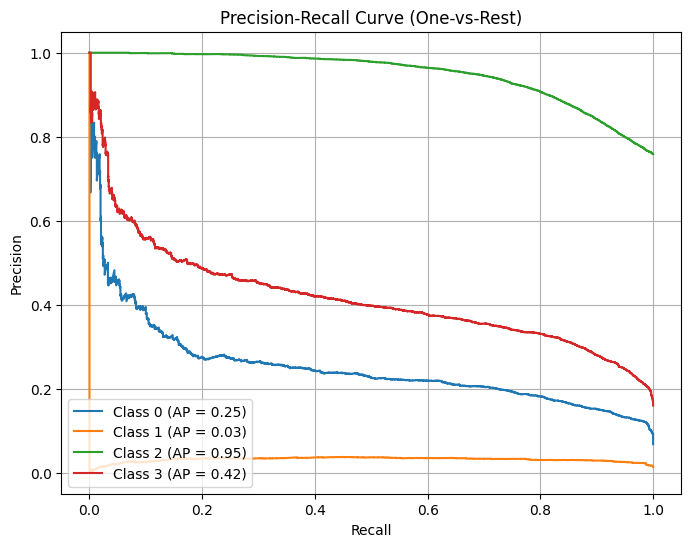

In [57]:
plot_precision_recall_curve(resnet_no_aug_loaded_y_true, resnet_no_aug_loaded_y_probs)

The Precision-Recall (PR) Curve provides an evaluation of the model's ability to balance precision and recall for each class in the multi-class Alzheimer's disease classification. Key observations include:

1. Class-Specific Performance:
- Class 2 (AP = 0.95):
    - This class has the highest Average Precision (AP), indicating that the model performs exceptionally well in distinguishing this class from others.
    - The curve remains close to high precision across a wide range of recall values, reflecting a strong balance between precision and recall.

- Class 3 (AP = 0.42):
    - Moderately high performance, with better precision-recall balance compared to other classes (excluding Class 2).
    - The curve demonstrates reasonable precision at medium recall levels.

- Class 0 (AP = 0.25):
    - Performance for this class is suboptimal, with the curve showing significant drops in precision as recall increases.
    - This suggests difficulty in correctly predicting this class when aiming to capture more samples.

- Class 1 (AP = 0.03):
    - The poorest performance among all classes, with very low precision across almost all recall values.
    - This indicates that the model struggles significantly to identify this class, leading to many false positives and missed samples.

2. Overall Trends:
- The model's performance is highly uneven across classes:
    - Class 2 demonstrates strong separation from other classes, suggesting that the features distinguishing it are well-represented in the data.
    - Class 1, in contrast, suffers from extremely poor precision and recall, likely due to data overlap or insufficient representation of distinguishing features in the dataset.
- The AP scores highlight a significant imbalance in how well the model handles different classes.

3. Implications for the Model:
- Class 2's strong performance may dominate metrics like accuracy, but poor AP for Classes 0 and 1 indicates that the model is unreliable for a subset of the dataset.
- Class 1's weak performance could reflect:
    - Insufficient data for this class (class imbalance).
    - Overlap in features with other classes, especially Class 0 and Class 3.
- The model needs improvement to ensure a more consistent performance across all classes.

## Model 1 - ResNET50 Summary

**Overall Model Insights:**
1. Training and Validation Loss:
- The training loss decreases consistently, indicating effective learning during training.
- Validation loss decreases initially but stabilizes and slightly increases after epoch 10, pointing to overfitting. The model memorizes training data instead of generalizing effectively for unseen data.

2. Training and Validation Accuracy:
- Training accuracy steadily improves, reaching approximately 0.45 by the end of training.
- Validation accuracy peaks around epoch 8-10 but fluctuates afterward, further confirming overfitting.

**Performance Across Classes:**
1. ROC Curve:
- Class 2 (AUC = 0.85) and Class 0 (AUC = 0.84) show strong performance, indicating that the model can effectively distinguish these stages of Alzheimer's.
- Class 3 (AUC = 0.81) has moderate performance, reflecting some overlap with other classes.
- Class 1 (AUC = 0.78) has the weakest performance, highlighting challenges in differentiating this class.

2. Confusion Matrix:
- The model performs best for the Non-Demented class, with 12,464 samples correctly classified.
- Significant misclassifications are observed for:
    - Mild Dementia (often predicted as Very Mild Dementia or Non-Demented).
    - Very Mild Dementia (frequently misclassified as Non-Demented).
    - Moderate Dementia (misclassified across multiple categories).
- The confusion matrix reveals challenges in distinguishing adjacent dementia stages, likely due to overlapping features.

3. Precision-Recall Curve:
- Class 2 (AP = 0.95) achieves the highest precision and recall balance, indicating robust classification for this class.
- Class 3 (AP = 0.42) performs moderately, with reasonable precision at medium recall levels.
- Class 0 (AP = 0.25) and Class 1 (AP = 0.03) have poor precision-recall balance, with Class 1 being the weakest.


**Key Challenges:**
- Class Imbalance: The model is biased toward the Non-Demented class, reflected in its dominance in predictions.
- Overlap Between Classes: Adjacent stages of dementia, such as Mild Dementia and Very Mild Dementia, are difficult to distinguish due to shared features.
- Generalization Issues: Overfitting limits the model’s performance on unseen data, as indicated by diverging validation metrics.


## Model 2 - VGG16

In [58]:
# vgg16_no_aug_trained, vgg16_no_aug_results, vgg16_no_aug_y_true, vgg16_no_aug_y_pred, vgg16_no_aug_y_probs = train_with_validation(vgg16_no_aug, train_loader_no_aug, 
#                                                                                                                                         vgg16_no_aug_loss, vgg16_no_aug_optim, 35, test_loader) 


In [59]:
# save_model(vgg16_no_aug_trained, vgg16_no_aug_results, vgg16_no_aug_y_true, vgg16_no_aug_y_pred, vgg16_no_aug_y_probs,"vgg16_no_aug.pth")

In [60]:
vgg16_no_aug_loaded, vgg16_no_aug_loaded_results, vgg16_no_aug_loaded_y_true, vgg16_no_aug_loaded_y_pred, vgg16_no_aug_loaded_y_probs = open_saved_model(model_path_vgg16_no_aug, arch="vgg16")

Model (vgg16) and results loaded from /kaggle/input/models/vgg16_no_aug.pth.


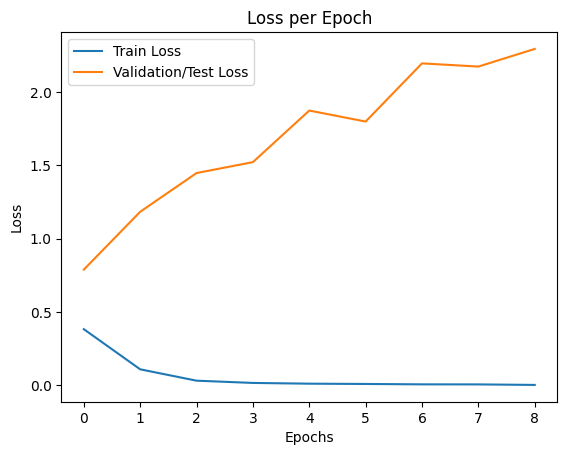

In [61]:
plot_loss(vgg16_no_aug_loaded_results["epochs"], vgg16_no_aug_loaded_results["train_loss"], vgg16_no_aug_loaded_results["val_loss"])

This plot illustrates the "Loss per Epoch" for both training and validation/test sets of the second model. Key observations include:

1. Training Loss:
- The training loss decreases rapidly and stabilizes close to zero after just a few epochs.
- This indicates that the model is overfitting to the training data very quickly, as it achieves near-perfect optimization on the training set.

2. Validation/Test Loss:
- The validation/test loss consistently increases after the initial epoch.
- This trend suggests poor generalization, as the model performs worse on unseen data with continued training.

3. Overfitting:
- The divergence between training loss and validation loss is significant and occurs early in the training process.
- This suggests that the model is overfitting heavily, learning the training data perfectly but failing to capture patterns applicable to the validation set.

4. Implications:
- The increasing validation loss is a clear indicator that the model is memorizing the training data instead of generalizing effectively.
- The model architecture, data preprocessing, or training strategy may need adjustments to address this behavior.

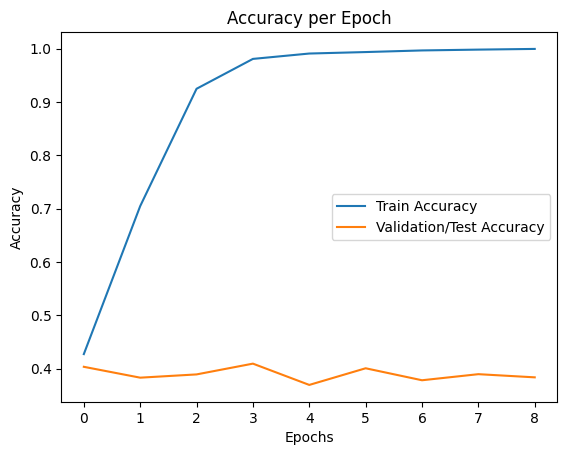

In [62]:
plot_accuracy(vgg16_no_aug_loaded_results["epochs"], vgg16_no_aug_loaded_results["train_accuracy"], vgg16_no_aug_loaded_results["val_accuracy"])

This plot shows the "Accuracy per Epoch" for both training and validation/test sets of the VGG16 model. Key observations include:

1. Training Accuracy:
- The training accuracy increases sharply and reaches nearly 100% after just a few epochs.
- This rapid rise to perfection indicates that the model is overfitting to the training data, memorizing the patterns without generalizing.

2. Validation/Test Accuracy:
- The validation accuracy remains almost flat throughout the training process, fluctuating around 40%.
- This lack of improvement on the validation set suggests poor generalization, meaning the model fails to capture meaningful patterns applicable to unseen data.

3. Overfitting:
- The significant gap between training and validation accuracy indicates overfitting. The model performs exceptionally well on the training data but fails to extend this performance to the validation set.
- The validation accuracy plateau suggests the model is unable to adapt to the validation data, despite continued optimization on the training set.

4. Implications:
- The VGG16 model is too complex for the current dataset or lacks proper regularization, leading to its inability to generalize.
- The validation accuracy plateau indicates that the model may be struggling with either insufficient data or overlapping features among classes.

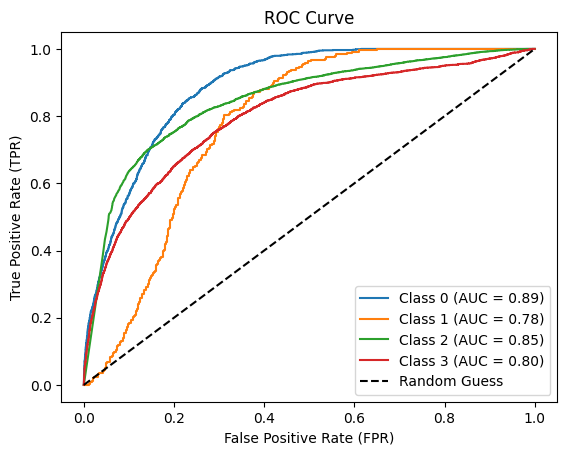

In [63]:
plot_roc_curve(vgg16_no_aug_loaded_y_true,vgg16_no_aug_loaded_y_probs)

This ROC Curve evaluates the performance of the VGG16 model across four classes using the Area Under the Curve (AUC) as a key metric. Key observations include:

1. Class-Specific Performance:
- Class 0 (AUC = 0.89):
    - The highest AUC among all classes, indicating strong performance in distinguishing this class from others.
    - The curve remains close to the top-left corner, which represents high true positive rates (TPR) and low false positive rates (FPR).
- Class 1 (AUC = 0.78):
    - The lowest AUC score, suggesting challenges in differentiating this class from the others.
    - This indicates potential overlap in features between Class 1 and neighboring classes.
- Class 2 (AUC = 0.85):
    - Strong performance, second only to Class 0, reflecting good model capability in identifying this class.
    - The curve consistently deviates from the diagonal random guess line, demonstrating meaningful predictions.
- Class 3 (AUC = 0.80):
    - Moderate performance, with better separation compared to Class 1 but lower than Class 0 and Class 2.

2. General Trends:
- All classes show AUC values above 0.75, indicating acceptable discriminatory power.
- There is notable variability in performance across classes, highlighting the model's uneven ability to generalize to different stages of Alzheimer's disease.
- The ROC curve for Class 1 is closest to the random guess line, confirming its weaker classification.

3. Implications for Multi-Class Classification:
- The high AUC for Class 0 and Class 2 indicates that the model is well-suited to identifying these classes.
- The lower AUC for Class 1 suggests the need for additional focus on improving classification for this class.
- Moderate performance for Class 3 reflects the model's partial ability to distinguish it, with room for optimization.


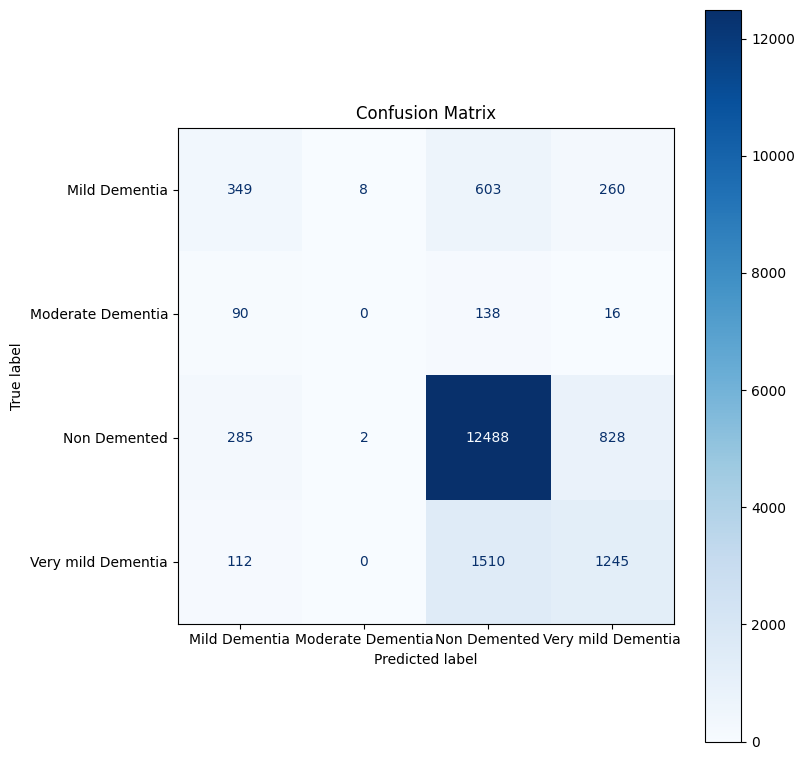

In [64]:
plot_confusion_matrix(vgg16_no_aug_loaded_y_true,vgg16_no_aug_loaded_y_pred, class_names)

The confusion matrix evaluates the performance of the VGG16 model on the multi-class classification task for Alzheimer’s disease stages. Key insights include:

1. Class-Specific Performance:
- Non-Demented:
    - The model performs best for this class, with 12,488 correctly classified samples.
    - However, there is notable misclassification, with 828 samples misclassified as Very Mild Dementia and 285 samples misclassified as Mild Dementia.
- Mild Dementia:
    - Out of all true Mild Dementia samples, 349 are correctly classified, but a large portion is misclassified as Non-Demented (603) and Very Mild Dementia (260).
    - This highlights difficulty in distinguishing this class.
- Moderate Dementia:
    - 0 samples correctly classified , 138 samples are classified as Non-Demented, and 90 as Mild Dementia.
- Very Mild Dementia:
    - The model correctly classifies 1,245 samples, but a significant number (1,510) are misclassified as Non-Demented.
    - This reflects high confusion between these two adjacent stages.

2. Misclassification Trends:
- There is significant confusion between Non-Demented and Very Mild Dementia, with many Non-Demented samples predicted as Very Mild Dementia and vice versa.

3. Class Imbalance:
- The dominance of correctly classified Non-Demented samples shows class imbalance, which biases the model toward predicting this class more accurately.

4. Implications:
- The model struggles to differentiate between neighboring stages of Alzheimer’s disease, especially Non-Demented vs. Very Mild Dementia and Mild Dementia vs. Non-Demented.
- This is a common issue in medical datasets where class boundaries are not distinct due to overlapping features.

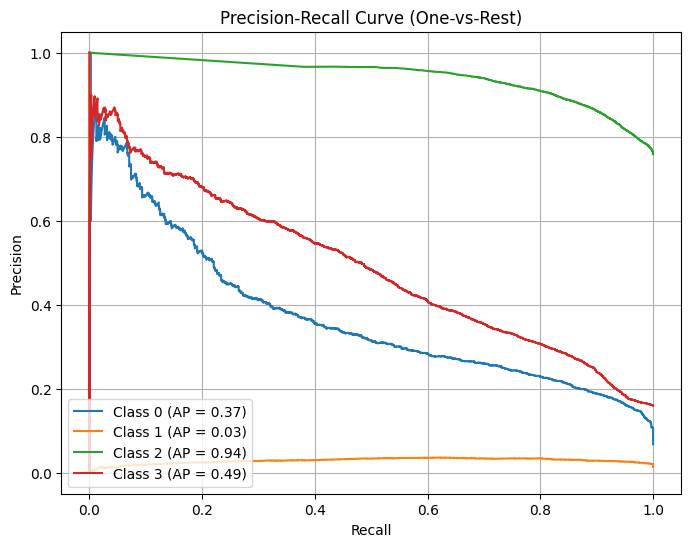

In [65]:
plot_precision_recall_curve(vgg16_no_aug_loaded_y_true, vgg16_no_aug_loaded_y_probs)

This Precision-Recall (PR) Curve evaluates the performance of the VGG16 model for a multi-class classification problem, considering the dataset's imbalance. Here are the key observations:

1. Class-Specific Performance:
- Class 0 (AP = 0.37):
    - Moderate performance, but the precision decreases rapidly as recall increases, indicating challenges in maintaining high precision when capturing more samples.
    - The curve suggests the model struggles with correctly identifying samples for this class while minimizing false positives.
- Class 1 (AP = 0.03):
    - Extremely poor performance, with nearly flat precision across all recall values.
    - This indicates significant difficulty in distinguishing Class 1, likely due to insufficient representation in the dataset or significant overlap with other classes.
- Class 2 (AP = 0.94):
    - Outstanding performance, with consistently high precision and recall values.
    - The curve demonstrates the model's strong ability to correctly classify Class 2, reflecting the presence of clear features differentiating this class.
- Class 3 (AP = 0.49):
    - Moderate performance, with better precision-recall balance than Class 0 and Class 1 but significantly weaker than Class 2.
    - Precision declines steadily as recall increases, suggesting some difficulty in identifying Class 3 without introducing false positives.

2. General Trends:
    - The high AP for Class 2 (0.94) highlights that this class benefits from distinct, well-represented features in the dataset.
    - The poor AP for Class 1 (0.03) is a clear indicator of class imbalance or overlapping features, which makes distinguishing this class particularly challenging.
    - Classes 0 and 3 show moderate performance, indicating room for improvement in their classification.

3. Implications for Imbalanced Data:
    - The dataset imbalance significantly impacts Class 1, as indicated by the very low AP. This could also negatively influence the model's generalization capability.
    - Class 2's high AP might dominate overall metrics, masking the poor performance of other classes, such as Class 1.

## Model 2 - VGG16 Summary

The VGG16 model's performance has been analyzed using multiple metrics, including loss, accuracy, ROC curves, confusion matrices, and precision-recall curves. Here are the consolidated findings:

1. Loss and Accuracy Trends
- Training Loss and Accuracy:
    - The training loss decreases to near-zero quickly, and the accuracy reaches almost 100% after a few epochs.
    - This indicates that the model is highly overfitted to the training data.
- Validation/Test Loss and Accuracy:
    - Validation loss increases steadily after the first epoch, suggesting poor generalization.
    - Validation accuracy remains flat at approximately 40%, confirming the inability to capture meaningful patterns from unseen data.
- Implication: The model overfits significantly, failing to generalize beyond the training set.

2. ROC Curves
- Class 0 (AUC = 0.89):
     - Strong performance, showing good discrimination for this class.
- Class 1 (AUC = 0.78):
    - Weakest performance among all classes, indicating challenges in distinguishing this class from others.
- Class 2 (AUC = 0.85):
    - Strong performance, reflecting good separation for this class.
- Class 3 (AUC = 0.80):
    - Moderate performance, with acceptable but not optimal discrimination.
- Implication: While the model performs well for some classes (e.g., Class 0 and Class 2), its performance for others, especially Class 1, is suboptimal, highlighting imbalanced learning.

3. Confusion Matrix
- Non-Demented:
    - Most samples are correctly classified, with 12,488 true positives.
    - However, there is significant misclassification, with many samples incorrectly predicted as Very Mild Dementia (828) and Mild Dementia (285).
- Mild Dementia:
    - Out of all true samples, only 349 are correctly classified, with significant misclassification as Non-Demented (603) and Very Mild Dementia (260).
- Moderate Dementia:
    - 0 correctly classified samples.
- Very Mild Dementia:
    - While 1,245 samples are correctly classified, many (1,510) are misclassified as Non-Demented.
- Implication: There is a clear bias toward the Non-Demented class, with high confusion among overlapping dementia stages.

4. Precision-Recall Curves
- Class 2 (AP = 0.94):
    - The highest AP, showing excellent precision and recall balance.
- Class 0 (AP = 0.37) and Class 3 (AP = 0.49):
    - Moderate performance, with declining precision as recall increases.
- Class 1 (AP = 0.03):
    - Extremely poor performance, indicating severe difficulty in distinguishing this class.
- Implication: The dataset imbalance severely affects the model's ability to classify minority or overlapping classes like Class 1.

5. Overall Observations
- The model demonstrates high overfitting due to its complexity relative to the dataset size and diversity.
- Strong performance for dominant classes (e.g., Non-Demented and Class 2) masks poor performance for other classes.
- Dataset imbalance amplifies misclassification for minority or overlapping classes, particularly Class 1 and Moderate Dementia.

The VGG16 model achieves reasonable performance for certain classes but fails to generalize due to overfitting and dataset imbalance. Significant adjustments to data preprocessing, model architecture, and training strategies are required to achieve reliable, balanced classification across all Alzheimer's disease stages.

## Model 3 - EfficientNet-B4

In [66]:
# effnet_b4_no_aug_trained, effnet_b4_no_aug_results, effnet_b4_no_aug_y_true, effnet_b4_no_aug_y_pred, effnet_b4_no_aug_y_probs = train_with_validation(effnet_b4_no_aug, train_loader_no_aug_effnetB4, 
#                                                                                                                                         effnet_b4_no_aug_loss, effnet_b4_no_aug_optim, 35, test_loader_effnetB4) 


In [67]:
# save_model(effnet_b4_no_aug_trained, effnet_b4_no_aug_results, effnet_b4_no_aug_y_true, effnet_b4_no_aug_y_pred, effnet_b4_no_aug_y_probs,"effnet_b4_no_aug.pth")

In [68]:
effnet_b4_no_aug_loaded, effnet_b4_no_aug_loaded_results, effnet_b4_no_aug_loaded_y_true,effnet_b4_no_aug_loaded_y_pred, effnet_b4_no_aug_loaded_y_probs = open_saved_model(model_path_effnet_no_aug, arch="efficientnet_b4")

Model (efficientnet_b4) and results loaded from /kaggle/input/models/effnet_b4_no_aug (1).pth.


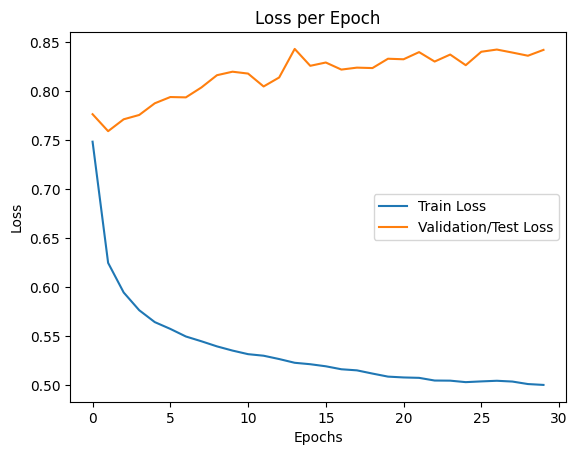

In [69]:
plot_loss(effnet_b4_no_aug_loaded_results["epochs"], effnet_b4_no_aug_loaded_results["train_loss"], effnet_b4_no_aug_loaded_results["val_loss"])

This plot illustrates the "Loss per Epoch" for the model, showing both training and validation/test losses. Below are key observations and implications:

1. Training Loss:
- The training loss decreases steadily across epochs, indicating that the model is learning and optimizing well on the training dataset.
- By the end of training, the training loss reaches a relatively low value (~0.50), suggesting effective convergence.

2. Validation/Test Loss:
- The validation loss starts higher than the training loss and does not decrease significantly throughout the training process.
- Instead, it exhibits an increasing trend after approximately epoch 10, which is a strong indicator of overfitting.
- The gap between training and validation loss becomes more pronounced as epochs progress, confirming that the model performs well on training data but struggles to generalize to unseen data.

3. Overfitting Issue:
- The divergence between training and validation loss suggests that the model memorizes the training data rather than generalizing well.
- This problem is particularly relevant when working with imbalanced data, as the model might be biased toward the majority class, leading to poor generalization on underrepresented classes.

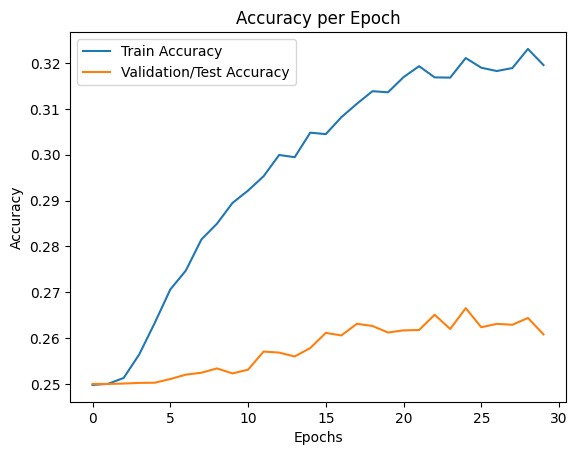

In [70]:
plot_accuracy(effnet_b4_no_aug_loaded_results["epochs"], effnet_b4_no_aug_loaded_results["train_accuracy"], effnet_b4_no_aug_loaded_results["val_accuracy"])

This plot illustrates the "Accuracy per Epoch" for the model, showing both training accuracy and validation/test accuracy. Below are key observations and implications:

1. Training Accuracy:
- The training accuracy increases steadily across epochs, indicating that the model is effectively learning patterns from the training data.
- By the end of training, the accuracy reaches approximately 0.32, suggesting that the model performs well on the training set.
- This continuous improvement indicates that the model is optimizing well for the training distribution.

2. Validation/Test Accuracy:
- The validation accuracy starts very low and shows minimal improvement throughout the training process.
- While it does increase slightly in the initial epochs, it remains significantly lower than the training accuracy.
- Around epoch 10, the accuracy stabilizes with fluctuations but does not show meaningful improvement, peaking at ~0.26.
- The large gap between training and validation accuracy suggests that the model is memorizing the training data but failing to generalize to unseen data.

3. Overfitting Issue:
- The growing discrepancy between training and validation accuracy indicates severe overfitting.
- The model performs well on training data but struggles to classify validation/test samples accurately.
- Given the imbalanced dataset, it is possible that the model is biased toward the majority class, leading to poor performance on minority classes.

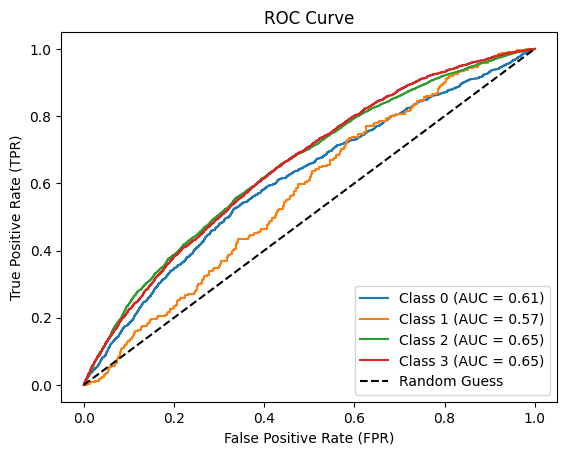

In [71]:
plot_roc_curve(effnet_b4_no_aug_loaded_y_true, effnet_b4_no_aug_loaded_y_probs)

This plot illustrates the ROC (Receiver Operating Characteristic) Curve, which evaluates the performance of a multi-class classification model by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) for each class. The AUC (Area Under the Curve) values indicate the model’s ability to distinguish between different classes.


1. Class-wise AUC Scores:
- Class 0 (Blue) → AUC = 0.61
- Class 1 (Orange) → AUC = 0.57 (lowest performance)
- Class 2 (Green) → AUC = 0.65
- Class 3 (Red) → AUC = 0.65 (highest performance)

2. Interpretation of AUC Values:
- An AUC of 0.5 represents a completely random classifier, meaning no discriminative power.
- In this case, all AUC values are only slightly above 0.5, suggesting that the model has very weak predictive power and struggles to distinguish between the different classes.
- Class 1 has the lowest AUC (0.57), meaning it is the hardest for the model to classify correctly.
- Classes 2 and 3 perform slightly better (AUC = 0.65), but still indicate a suboptimal model.

3. Comparison to Random Guessing:
- The dashed diagonal line (Random Guessing) represents a model with no discriminatory power (AUC = 0.5).
- Since the ROC curves are close to this diagonal line, it suggests that the model performs only slightly better than random guessing, which is a concerning result.


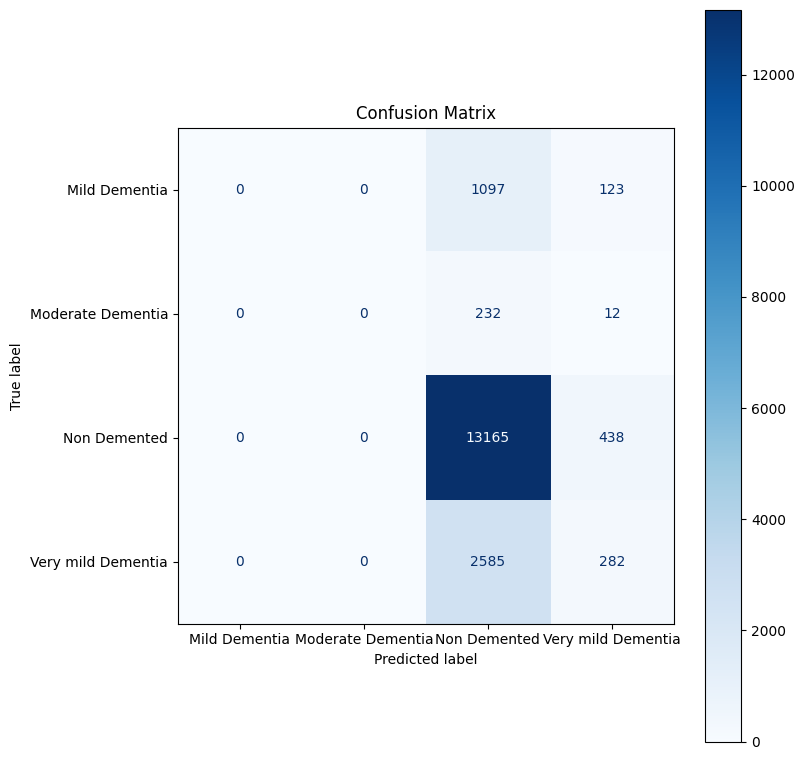

In [72]:
plot_confusion_matrix(effnet_b4_no_aug_loaded_y_true, effnet_b4_no_aug_loaded_y_pred, class_names)

This confusion matrix evaluates the performance of the EfficientNetB4 model for multi-class classification of Alzheimer’s disease stages. The matrix highlights how well the model distinguishes between four categories: Mild Dementia, Moderate Dementia, Non-Demented, and Very Mild Dementia.

1. Class-Specific Performance:
- Mild Dementia:
    - The model completely fails to correctly classify Mild Dementia, with 0 correct predictions.
    - Instead, 1,097 samples are misclassified as Non-Demented, and 123 samples as Very Mild Dementia.
    - This indicates a severe issue in detecting this stage of the disease.

- Moderate Dementia:
    - The model also fails to classify any cases of Moderate Dementia correctly.
    - Most samples are misclassified as Non-Demented (232 cases), while 12 are assigned to Very Mild Dementia.
    - This suggests that the model struggles to differentiate Moderate Dementia from Non-Demented individuals.

- Non-Demented:
    - This class is the best classified, with 13,165 correct predictions.
    - However, 438 samples are misclassified as Very Mild Dementia, indicating some level of overlap between these conditions.
    - The strong bias toward this class suggests that the model leans toward predicting "Non-Demented" due to dataset imbalance.

- Very Mild Dementia:
    - Correctly classified: 282 samples.
    - However, 2,585 samples are misclassified as Non-Demented, showing significant confusion between these two categories.
    - This highlights the challenge of distinguishing early-stage dementia from normal cognitive function.

2. Misclassification Trends:
- Severe Bias Towards the Non-Demented Class:
    - The vast majority of predictions fall into the Non-Demented category, indicating that the model is overfitting to the dominant class in the dataset.
- High Confusion Between Neighboring Dementia Stages:
    - Mild Dementia is mostly mistaken for Non-Demented, suggesting that the model fails to recognize mild cognitive impairment.
    - Very Mild Dementia is frequently misclassified as Non-Demented, which is problematic for early diagnosis of Alzheimer’s disease.


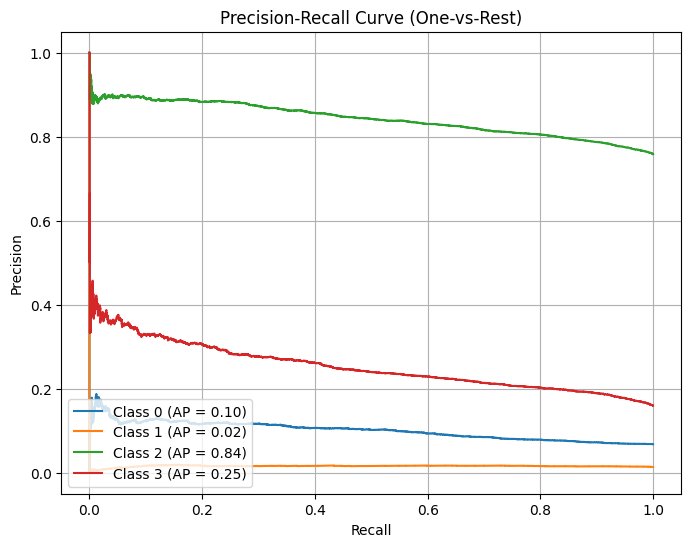

In [73]:
plot_precision_recall_curve(effnet_b4_no_aug_loaded_y_true, effnet_b4_no_aug_loaded_y_probs)

This plot illustrates the Precision-Recall (PR) curves for a multi-class classification task, evaluating the model’s ability to distinguish between four classes. The Average Precision (AP) values for each class indicate overall performance.

1. Class-Specific Performance:
- Class 0 (AP = 0.10, Blue Curve)
    - Precision remains low across all recall values.
    - The model struggles to maintain precision even for lower recall values, indicating poor discrimination for this class.
- Class 1 (AP = 0.02, Orange Curve)
    - This is the worst-performing class, with an AP of only 0.02, suggesting that the model fails to distinguish this class from others.
    - Precision is nearly zero for all recall values, meaning that most predictions for this class are incorrect.
- Class 2 (AP = 0.84, Green Curve)
    - The best-performing class, with high AP (0.84).
    - Precision remains above 0.8 across most recall values, indicating that the model is highly confident and accurate when predicting this class.
    - This suggests a strong bias toward this class, likely due to class imbalance.
- Class 3 (AP = 0.25, Red Curve)
    - Performs slightly better than Class 0 and Class 1 but still poorly overall.
    - Precision declines sharply as recall increases, indicating significant misclassification issues.

2. Misclassification Trends:
- Extreme Class Imbalance is Evident:
    - Class 2 performs exceptionally well, while Classes 0, 1, and 3 struggle significantly.
    - The worst performance for Class 1 (AP = 0.02) suggests that the model has almost no ability to recognize this class.
- High False Positive Rates:
    - The low AP scores for Classes 0, 1, and 3 indicate that the model frequently misclassifies these cases into other categories.
    - Given the earlier confusion matrix, it is likely that these misclassified samples are being assigned to Class 2 (Non-Demented).
- Overfitting to the Majority Class (Class 2):
    - The model likely memorizes dominant patterns in the dataset, resulting in high confidence for Class 2 but poor generalization to other categories.


## Model 3 - EfficientNet-B4 Summary

Revised Model Performance Summary for EfficientNetB4
1. Loss and Accuracy Trends
- Training Loss:
    - The training loss steadily decreases across epochs, indicating that the model is successfully optimizing on the training data.
    - By the end of training, the loss reaches ~0.50, which suggests that the model has learned patterns from the training dataset.
- Validation/Test Loss:
    - The validation loss starts higher than the training loss and fails to improve significantly.
    - Instead of decreasing, validation loss fluctuates and increases after epoch 10, which is a strong indication of overfitting.
    - This suggests that the model fails to generalize well to unseen data.
- Overfitting:
    - The widening gap between training and validation loss confirms severe overfitting.
    - The model performs well on training data but struggles on validation data, particularly for underrepresented classes.

2. Accuracy per Epoch
- Training Accuracy:
    - The training accuracy steadily increases, reaching ~0.32 by the end of training.
    - This suggests that the model is learning patterns from the training data effectively.
- Validation/Test Accuracy:
    - The validation accuracy remains consistently low throughout training.
    - It starts at ~0.25 and fluctuates around ~0.26, showing minimal improvement.
    - The large gap between training and validation accuracy highlights the model's failure to generalize to unseen samples.
- Implications:
    - The severe overfitting leads to poor real-world performance.
    - The model is likely biased toward the majority class, making it unreliable for detecting Alzheimer's stages.

3. ROC Curves & Class Discrimination
- Class 0 (AUC = 0.61): Weak discrimination, slightly better than random guessing.
- Class 1 (AUC = 0.57): Worst performance, indicating the model struggles to classify this stage.
- Class 2 (AUC = 0.65): Best performance, but still far from ideal.
- Class 3 (AUC = 0.65): Moderate performance, similar to Class 2.
- General Trends:
    - All AUC values remain close to 0.5, meaning the model barely performs better than random guessing.
    - Class 1 is the hardest to classify, confirming earlier findings from the confusion matrix.
    - The model lacks strong discriminative power across all classes.

4. Confusion Matrix - Class Performance
- Non-Demented:
    - Best classification performance, with 13,165 correctly classified samples.
    - However, 438 samples are misclassified as Very Mild Dementia, indicating some overlap.
- Mild Dementia:
    - 0 correct classifications → Total failure in detecting this stage.
    - Most cases (1,097) are misclassified as Non-Demented, meaning the model fails to recognize mild cognitive impairment.
- Moderate Dementia:
    - 0 correct classifications → Completely undetected.
    - The majority (232 cases) are misclassified as Non-Demented, reinforcing class imbalance issues.
- Very Mild Dementia:
    - 282 correctly classified samples, but 2,585 are misclassified as Non-Demented.
    - This shows significant confusion between early dementia stages and healthy cases.
- Implications:
    - The model is strongly biased toward the Non-Demented class, likely due to class imbalance.
    - Early Alzheimer's stages (Mild & Moderate Dementia) are almost never detected, making the model clinically unusable in its current form.
    - The confusion between Very Mild Dementia and Non-Demented cases is problematic for early detection of Alzheimer's.

5. Precision-Recall Curves & Class Imbalance Effects
- Class 2 (AP = 0.84): Best performance, meaning this class is overrepresented in training data.
- Class 3 (AP = 0.25): Moderate performance, but still unreliable.
- Class 0 (AP = 0.10): Poor performance, indicating high false positive rates.
- Class 1 (AP = 0.02): Worst performance, showing that the model completely fails to recognize this class.
- General Trends:
    - The low AP scores for Classes 0, 1, and 3 confirm severe class imbalance issues.
    - Precision drops sharply, meaning misclassification rates are high.
    - The model strongly favors Class 2, which is likely the dominant class in the dataset.

6. Overall Summary & Next Steps
- Key Issues Identified
    - Severe Overfitting: The model memorizes training data but fails to generalize.
    - Bias Toward Non-Demented Class: Most samples are classified as Non-Demented.
    - Failure to Classify Mild and Moderate Dementia: These critical stages have 0 correct classifications.
    - Poor Discriminative Power: AUC values remain close to 0.5, meaning the model is barely better than random guessing.
    - Class Imbalance Issues: Precision-Recall curves confirm low precision/recall for minority classes.

## Summary of the Model's Performance on the Unaugmented Dataset

In [74]:
df1 = pd.DataFrame(resnet_no_aug_loaded_results).mean()
df2 = pd.DataFrame(vgg16_no_aug_loaded_results).mean()
df3 = pd.DataFrame(effnet_b4_no_aug_loaded_results).mean()



combined_df = pd.DataFrame({
    'Metric': df1.index,  
    'ResNET50_no_aug': df1.values,
    'VGG16_no_aug': df2.values,
    'EffNetB4_no_aug': df3.values,
}).reset_index(drop=True)

combined_df[::1].style.highlight_max(axis=1,subset=combined_df.columns[1:])

,Metric,ResNET50_no_aug,VGG16_no_aug,EffNetB4_no_aug
0,epochs,7.500000,4.000000,14.500000
1,train_loss,0.450919,0.062903,0.536013
2,val_loss,0.609828,1.696665,0.817045
3,train_accuracy,0.373413,0.890638,0.296840
4,val_accuracy,0.317240,0.389855,0.257736
5,train_precision,0.503910,0.940269,0.449963
6,val_precision,0.381970,0.436604,0.275688
7,train_recall,0.373413,0.890638,0.296840
8,val_recall,0.317240,0.389855,0.257736
9,train_f1,0.395047,0.900685,0.302512


# Training Models on Augmented Data

## Augmentation 

In [75]:
train_transform_augmentation = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomRotation(degrees=15),
    v2.RandomResizedCrop(size=(224, 224), scale=(0.85, 1.15)),
    v2.RandomAffine(degrees=0, shear=(-5, 5)),
    v2.RandomVerticalFlip(p=0.3),
    v2.RandomApply([v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0))], p=0.3),  # Blur to simulate acquisition noise
    v2.RandomApply([v2.GaussianNoise(mean=0.0, sigma=0.02, clip=True)],p=0.3),  # Add random Gaussian noise
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Prepare for ResNet50, VGG16, normalize 3 channels
])



test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((224,224), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# # EFFICIENTNET 
train_transform_augmentation_effnet = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomRotation(degrees=15),
    v2.RandomResizedCrop(size=(380, 380), scale=(0.85, 1.15)),
    v2.RandomAffine(degrees=0, shear=(-5, 5)),
    v2.RandomVerticalFlip(p=0.3),
    v2.RandomApply([v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0))], p=0.3),  # Blur to simulate acquisition noise
    v2.RandomApply([v2.GaussianNoise(mean=0.0, sigma=0.02, clip=True)],p=0.3),  # Add random Gaussian noise
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Prepare for ResNet50, VGG16, normalize 3 channels
])


test_transform_effnetB4 = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((380, 380), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [76]:
# Datasets 
train_dataset_augmented , test_dataset = create_data_sets(train_data, test_data, train_transform_augmentation, test_transform)

# DataLoaders
train_loader_augmented, test_loader = create_data_loaders(train_dataset_augmented,test_dataset,32)


## Model 1 - ResNET50

In [77]:
resnet_aug = initialize_resnet50()

resnet_aug_loss = nn.CrossEntropyLoss()
resnet_aug_optim = optim.Adam(resnet_aug.fc.parameters(), lr=1e-5)  

In [78]:
# resnet_augment_trained, resnet_augment_results, resnet_augment_y_true, resnet_augment_y_pred, resnet_augment_y_probs = train_with_validation(resnet_aug, train_loader_augmented, 
#                                                                                                                                         resnet_aug_loss, resnet_aug_optim, 35, test_loader) 

In [79]:
# save_model(resnet_augment_trained, resnet_augment_results, resnet_augment_y_true, resnet_augment_y_pred, resnet_augment_y_probs,"resnet_augmented.pth")

In [80]:
resnet_augment_loaded, resnet_augment_loaded_results, resnet_augment_loaded_y_true,resnet_augment_loaded_y_pred, resnet_augment_loaded_y_probs = open_saved_model(model_path_resnet_augment, arch="resnet50")

Model (resnet50) and results loaded from /kaggle/input/models/resnet_augmented.pth.


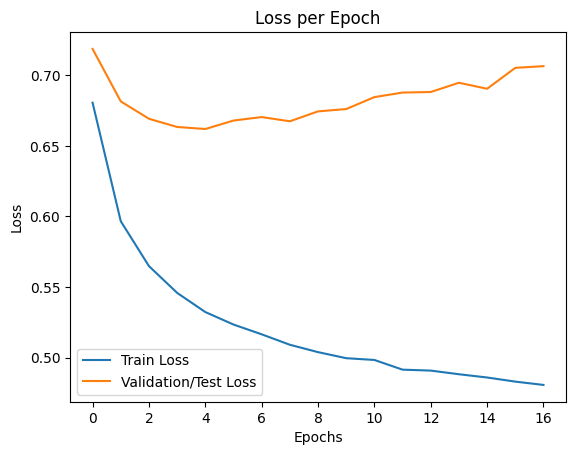

In [81]:
plot_loss(resnet_augment_loaded_results["epochs"], resnet_augment_loaded_results["train_loss"], resnet_augment_loaded_results["val_loss"])


The "Loss per Epoch" plot provides an overview of the model's training and validation performance over multiple epochs. Key insights from this graph include:

1. Training Loss:
- The training loss steadily decreases across epochs, indicating that the model is successfully optimizing on the training dataset.
- By the end of training, the loss reaches approximately 0.48, reflecting effective learning from the training data.

2. Validation/Test Loss:
- The validation loss starts higher than the training loss (~0.72) and decreases slightly in the initial epochs.
- However, after epoch 6–8, the validation loss stabilizes and then begins to increase, suggesting potential overfitting.
- By the later epochs, the validation loss remains consistently above 0.70, indicating that the model struggles to generalize to unseen data.

3. Overall Trend:
- The growing gap between training and validation loss suggests overfitting, as the model improves on the training data but fails to generalize.
- The increasing validation loss beyond epoch 10 indicates that the model may be memorizing the training set rather than learning generalizable patterns.


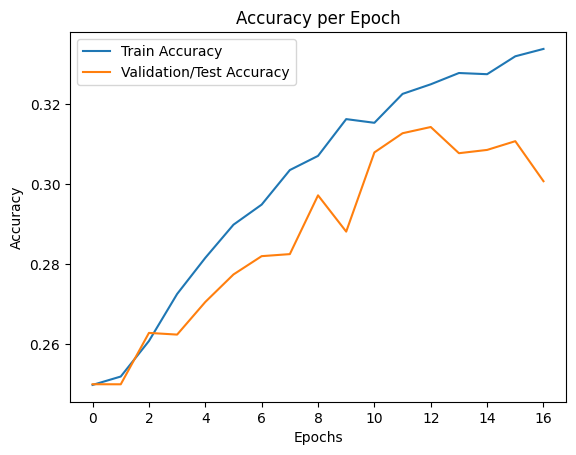

In [82]:
plot_accuracy(resnet_augment_loaded_results["epochs"], resnet_augment_loaded_results["train_accuracy"], resnet_augment_loaded_results["val_accuracy"])

The "Accuracy per Epoch" plot provides an overview of the model's performance during training and validation. Key insights from this graph include:

1. Training Accuracy:
- The training accuracy steadily increases across epochs, indicating that the model is successfully learning from the training data.
- By the end of training, the model reaches an accuracy of approximately 0.33, reflecting its ability to correctly classify a significant portion of the training data.

2. Validation/Test Accuracy:
- The validation accuracy improves consistently during the initial epochs, following a similar trend as the training accuracy.
- Around epoch 8–10, validation accuracy reaches its peak (~0.31), but fluctuates afterward, suggesting instability in generalization.
- The gap between training and validation accuracy remains moderate, but slight fluctuations in validation accuracy indicate possible inconsistencies in model performance.

3. Overall Trend:
- The steady increase in training accuracy confirms that the model is learning well on the training data.
- However, the fluctuations in validation accuracy suggest potential instability, which may indicate sensitivity to data variations.


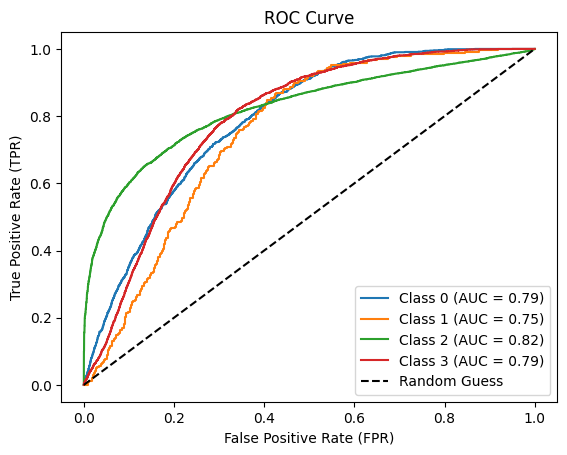

In [83]:
plot_roc_curve(resnet_augment_loaded_y_true,resnet_augment_loaded_y_probs)


The "ROC Curve" plot provides an evaluation of the model's ability to distinguish between different classes based on the True Positive Rate (TPR) and False Positive Rate (FPR). Key insights from this graph include:

1. Class-wise AUC Scores:
- Class 0 (AUC = 0.79): Shows good discrimination ability, indicating that the model can effectively classify this class.
- Class 1 (AUC = 0.75): The lowest AUC score, suggesting that the model has more difficulty distinguishing this class from others.
- Class 2 (AUC = 0.82): The best-performing class, with the highest AUC, indicating that the model is more confident in differentiating it.
- Class 3 (AUC = 0.79): Similar performance to Class 0, demonstrating moderate to strong class separability.

2. General Trends:
- All classes have AUC values above 0.75, which suggests that the model performs better than random guessing (AUC = 0.5).
- Class 2 stands out with the highest AUC (0.82), meaning it is the easiest for the model to classify correctly.
- Class 1 remains the most challenging class to distinguish, as reflected in its lower AUC score (0.75).
- The curves for Classes 0, 2, and 3 follow a steeper trajectory, indicating that the model achieves relatively high recall while keeping the false positive rate under control.

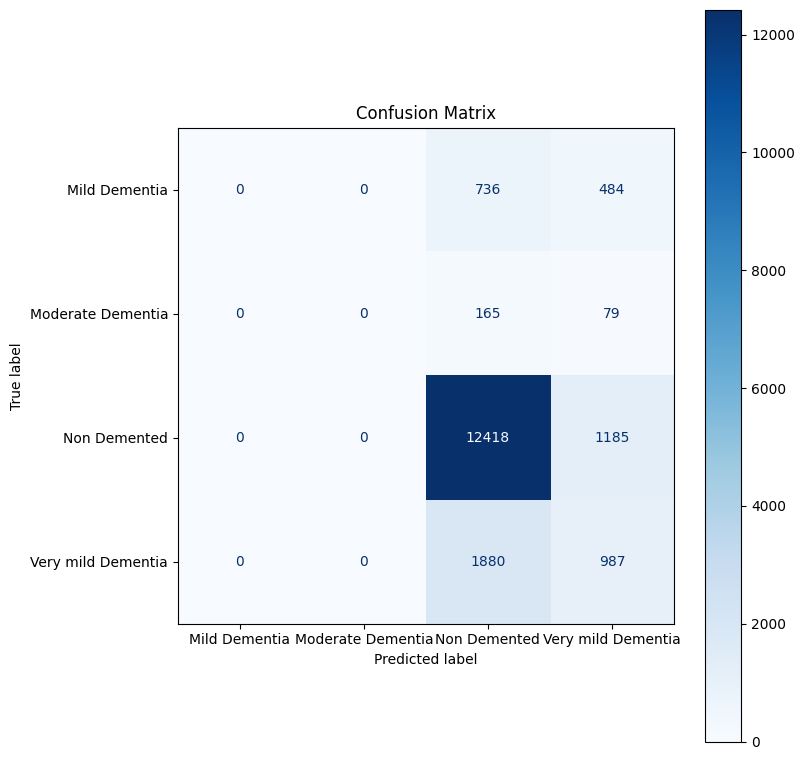

In [84]:
plot_confusion_matrix(resnet_augment_loaded_y_true,resnet_augment_loaded_y_pred,class_names)

The "Confusion Matrix" provides an in-depth analysis of the model's classification performance across different Alzheimer's disease stages. Key insights from this matrix include:

1. Class-Specific Performance:
- Mild Dementia:
    - 0 correct classifications → The model completely fails to recognize this class.
    - Most samples are misclassified as Non-Demented (736 cases) or Very Mild Dementia (484 cases).
    - This suggests that the model is unable to distinguish mild cognitive impairment from adjacent classes.
- Moderate Dementia:
    - 0 correct classifications, similar to Mild Dementia.
    - Most cases are misclassified as Non-Demented (165 cases) or Very Mild Dementia (79 cases).
    - Indicates that the model does not effectively capture features unique to Moderate Dementia.
- Non-Demented:
    - 12,418 correctly classified cases → The best-performing class.
    - However, 1,185 cases were misclassified as Very Mild Dementia, showing some degree of overlap between early dementia stages.
- Very Mild Dementia:
    - 2,867 total cases, but only 987 are correctly classified.
    - A large proportion (1,880 cases) are misclassified as Non-Demented, indicating high confusion between these two categories.

2. Misclassification Trends:
- The model heavily favors the Non-Demented class, likely due to class imbalance in the dataset.
- There is significant confusion between Very Mild Dementia and Non-Demented cases, suggesting that the model struggles with early-stage Alzheimer’s detection.
- No cases of Mild or Moderate Dementia were correctly classified, meaning the model does not effectively differentiate between progressive dementia stages.

3. Overall Trend:
- The confusion matrix highlights severe class imbalance issues, where the model is biased toward predicting Non-Demented individuals.
- The failure to classify Mild and Moderate Dementia suggests that the model is not learning discriminative features for these conditions.


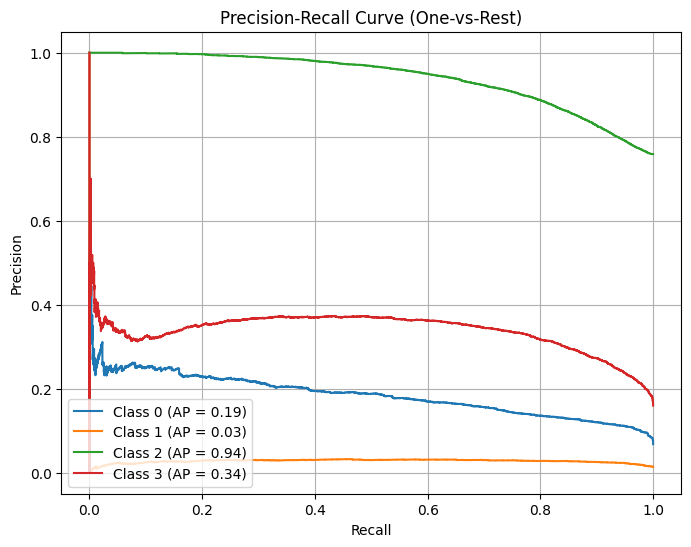

In [85]:
plot_precision_recall_curve(resnet_augment_loaded_y_true, resnet_augment_loaded_y_probs)

The "Precision-Recall Curve (One-vs-Rest)" plot provides insights into the model’s ability to correctly classify different Alzheimer’s disease stages by measuring precision and recall across varying decision thresholds. Key observations from this graph include:

1. Class-Specific Performance:
- Class 0 (AP = 0.19, Blue Curve):
    - Precision remains low across all recall values, indicating high misclassification rates for this class.
    - The model struggles to achieve high precision, even at lower recall values, suggesting difficulty in distinguishing this class from others.
- Class 1 (AP = 0.03, Orange Curve):
    - Worst performance among all classes, with an AP of only 0.03.
    - Precision remains flat near zero, meaning the model almost never correctly classifies this class.
    - Suggests complete failure in detecting Moderate Dementia cases, aligning with confusion matrix findings.
- Class 2 (AP = 0.94, Green Curve):
    - Best-performing class, with an AP of 0.94, indicating strong classification capability.
    - Precision remains consistently above 0.8 across most recall values, suggesting the model is highly confident in detecting this class.
    - Likely overrepresented in the dataset, leading to classification bias.
- Class 3 (AP = 0.34, Red Curve):
    - Moderate performance, with precision decreasing gradually as recall increases.
    - The model performs significantly better than for Class 0 and Class 1 but remains suboptimal.

2. General Trends:
- Extreme Class Imbalance is Evident:
    - Class 2 dominates performance, while Classes 0, 1, and 3 struggle significantly.
    - The worst performance for Class 1 (AP = 0.03) suggests that the model has almost no ability to correctly classify Moderate Dementia cases.
- High False Positive Rates:
    - The low AP scores for Classes 0 and 1 indicate that most predictions for these classes are incorrect.
    - This aligns with the confusion matrix, where many cases were misclassified as Non-Demented or Very Mild Dementia.
- Overfitting to the Majority Class (Class 2):
    - The model is highly confident in Class 2 but struggles with minority classes, suggesting dataset imbalance is affecting learning.
- Overall Trend:
    - The model performs well for Class 2 but poorly for all other classes, especially Class 1, which is almost never classified correctly.
    - The high AP for Class 2 suggests that the model is biased toward the Non-Demented class, while early-stage dementia cases remain difficult to distinguish.


## Model 1 - ResNet50 Summary on Augmented Data

1. Loss and Accuracy Trends
- Training Loss:
    - The training loss steadily decreases over epochs, showing that the model is successfully optimizing on the training dataset.
    - By the end of training, the loss reaches ~0.48, indicating that the model has effectively learned patterns from the data.
- Validation/Test Loss:
    - The validation loss starts at a higher level (~0.72) and initially decreases slightly.
    - After epoch 6–8, validation loss stabilizes and then starts increasing, suggesting overfitting.
- By the later epochs, validation loss remains consistently above 0.70, confirming poor generalization.
- Overfitting Evidence:
    - The growing gap between training and validation loss strongly suggests that the model is memorizing training data rather than generalizing to unseen samples.
    - This indicates a need for regularization techniques, such as Dropout, L2 weight decay, or Early Stopping.

2. Accuracy per Epoch
- Training Accuracy:
    - The training accuracy steadily increases, reaching ~0.33, confirming that the model is effectively learning from the training data.
- Validation/Test Accuracy:
    - The validation accuracy improves in early epochs, following the training trend, but starts fluctuating after epoch 8–10.
    - The model reaches a peak validation accuracy of ~0.31 but fails to improve beyond this point, indicating instability in generalization.
- Overall Implications:
    - The model exhibits unstable generalization, requiring improvements in data augmentation and class balancing to prevent biased learning.

3. ROC Curves and Discriminative Ability
- Class-wise AUC Scores:
    - Class 0 (AUC = 0.79): Moderate discrimination ability.
    - Class 1 (AUC = 0.75): Weakest classification performance.
    - Class 2 (AUC = 0.82): Best classification performance, suggesting strong feature separation.
    - Class 3 (AUC = 0.79): Similar to Class 0, moderate separability.
- Overall Trend:
    - All AUC values are above 0.75, indicating that the model performs better than random guessing (AUC = 0.5).
    - Class 2 has the highest AUC (0.82), showing that the model performs best on this category.
    - Class 1 is the hardest to classify (AUC = 0.75), suggesting a need for better feature representation.
    - The ROC curves indicate reasonable classification performance, but further tuning is required to enhance separation between overlapping classes.

4. Confusion Matrix and Misclassification Trends
- Non-Demented:
    - The best-performing class, with 12,418 correctly classified samples.
    - However, 1,185 samples were misclassified as Very Mild Dementia, suggesting an overlap in feature representation.
- Mild Dementia & Moderate Dementia:
    - 0 correct classifications → The model completely fails to recognize these classes.
    - Instead, samples are misclassified as Non-Demented or Very Mild Dementia, indicating that the model cannot distinguish between these stages.
- Very Mild Dementia:
    - 987 correctly classified samples, but 1,880 misclassified as Non-Demented, reinforcing the trend that early dementia stages are being ignored.
- Key Observations:
    - Severe class imbalance is evident, as the model is heavily biased towards Non-Demented individuals.
    - Early dementia stages (Mild & Moderate Dementia) are almost never detected, making the model unsuitable for real-world Alzheimer’s diagnosis.

5. Precision-Recall Analysis
- Class 2 (AP = 0.94):
    - The best-performing class, suggesting that the model is overfitting to this category.
- Class 0 (AP = 0.19) & Class 1 (AP = 0.03):
    - Worst-performing classes, with low precision across all recall values, meaning most classifications for these categories are incorrect.
    - Class 1 (AP = 0.03) is particularly concerning, as it implies near-zero recognition for Moderate Dementia.
- Key Trends:
    - The model struggles to classify underrepresented classes, reinforcing class imbalance issues.
    - High false positive rates, particularly for Non-Demented and Very Mild Dementia cases.
    - Further data balancing and loss function adjustments (e.g., focal loss) may be required.


6. Key Issues Identified:
- Severe Overfitting: The model performs well on training data but fails to generalize, as seen in the increasing validation loss.
- Bias Toward Non-Demented Class: The confusion matrix confirms that the model over-predicts Non-Demented individuals, making it unreliable for early Alzheimer’s detection.
- Failure to Recognize Early Dementia Stages: Moderate and Mild Dementia are never correctly classified, making the model clinically unusable.
- Class Imbalance Effects: The model overwhelmingly favors Class 2, which likely dominates the dataset, leading to poor classification for minority classes.

## Model 2 - VGG16

In [86]:
vgg16_aug = initialize_vgg16()

vgg16_aug_loss = nn.CrossEntropyLoss()
vgg16_aug_optim = optim.Adam(vgg16_aug.parameters(), lr=1e-5)  

In [87]:
# vgg16_augment_trained, vgg16_augment_results, vgg16_augment_y_true, vgg16_augment_y_pred, vgg16_augment_y_probs = train_with_validation(vgg16_aug, train_loader_augmented, 
#                                                                                                                                         vgg16_aug_loss, vgg16_aug_optim, 35, test_loader) 

In [88]:
# save_model(vgg16_augment_trained, vgg16_augment_results, vgg16_augment_y_true, vgg16_augment_y_pred, vgg16_augment_y_probs,"vgg16_augmented.pth")

In [89]:
vgg16_augment_loaded, vgg16_augment_loaded_results, vgg16_augment_loaded_y_true,vgg16_augment_loaded_y_pred, vgg16_augment_loaded_y_probs = open_saved_model(model_path_vgg16_augment, arch="vgg16")

Model (vgg16) and results loaded from /kaggle/input/models/vgg16_augmented.pth.


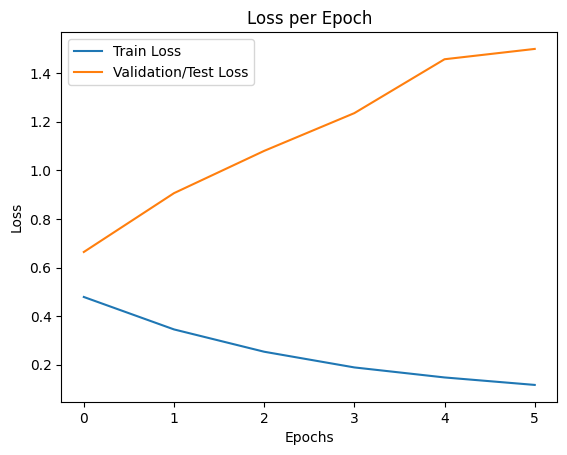

In [90]:
plot_loss(vgg16_augment_loaded_results["epochs"], vgg16_augment_loaded_results["train_loss"], vgg16_augment_loaded_results["val_loss"])

The "Loss per Epoch" plot provides insights into the model’s training and validation loss trends over multiple epochs. Key observations include:

1. Training Loss:
- The training loss steadily decreases over epochs, indicating that the model is effectively optimizing and learning from the training dataset.
- By the final epoch, the training loss is very low (~0.1), suggesting that the model has successfully minimized its error on the training set.
- This continuous downward trend confirms that the model is efficiently fitting the training data.

2. Validation/Test Loss:
- The validation loss follows an increasing trend, which is a strong indicator of overfitting.
- Instead of decreasing alongside training loss, the validation loss steadily increases and surpasses 1.4 by the final epoch.
- This suggests that while the model is becoming highly specialized in training data, it fails to generalize to unseen validation data.

3. Overall Trend:
- Severe overfitting is evident, as indicated by the growing gap between training and validation loss.
- The model is memorizing the training dataset but is unable to generalize to new examples, leading to poor validation performance.

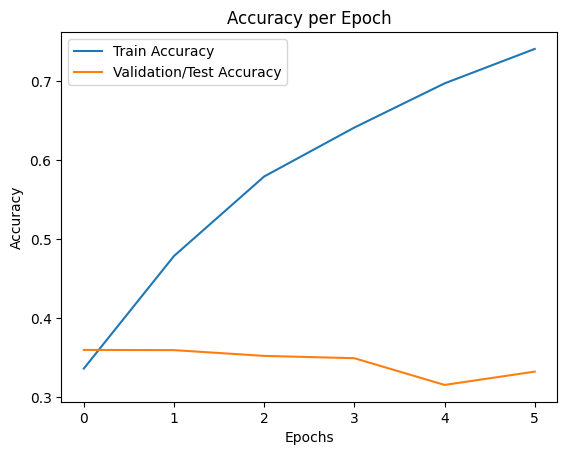

In [91]:
plot_accuracy(vgg16_augment_loaded_results["epochs"], vgg16_augment_loaded_results["train_accuracy"], vgg16_augment_loaded_results["val_accuracy"])

The "Accuracy per Epoch" plot provides an overview of how the model's classification performance evolves during training and validation. Key insights from this graph include:

1. Training Accuracy:
- The training accuracy steadily increases across epochs, indicating that the model is successfully learning from the training data.
- By the end of training, the model reaches an accuracy of approximately 0.72, which reflects strong optimization for the training dataset.
- The consistent upward trend suggests that the model is fitting the training data well without significant interruptions.

2. Validation/Test Accuracy:
 - The validation accuracy remains relatively flat throughout the training process, with only minor fluctuations.
- Instead of improving, validation accuracy slightly decreases after epoch 2, reaching its lowest point around epoch 4 before a slight recovery.
- By the final epoch, the validation accuracy is significantly lower than the training accuracy, suggesting that the model is struggling to generalize to unseen data.

3. Overall Trend:
- A clear divergence between training and validation accuracy is observed, which strongly indicates overfitting.
- While the model improves on the training set, it fails to transfer this learning to validation data, as seen in the nearly flat validation accuracy curve.
- The lack of improvement in validation accuracy suggests that the model may be memorizing the training data instead of learning generalizable features

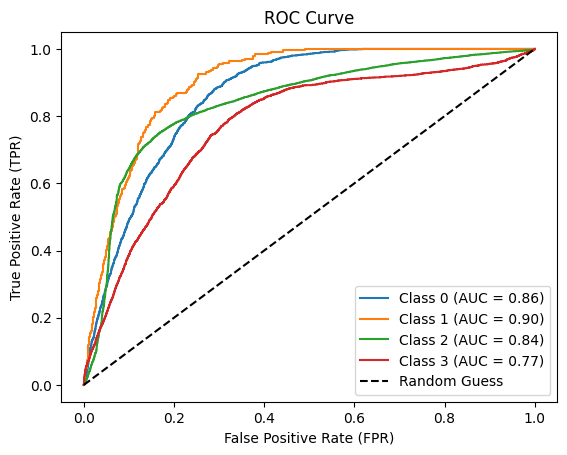

In [92]:
plot_roc_curve(vgg16_augment_loaded_y_true,vgg16_augment_loaded_y_probs)

The "ROC Curve" plot evaluates the model’s classification performance by measuring its ability to distinguish between different Alzheimer’s disease stages. Key insights from this graph include:

1. Class-wise AUC Scores:
- Class 0 (AUC = 0.86):
    - Demonstrates strong discrimination capability, meaning the model can effectively differentiate this class from others.
- Class 1 (AUC = 0.90):
    - The best-performing class, with the highest AUC score.
    - Indicates that the model is highly confident in classifying this category correctly.
- Class 2 (AUC = 0.84):
    - Exhibits good classification ability, though slightly weaker than Class 0 and Class 1.
    - Shows that the model can still differentiate this class well but may experience some confusion with similar categories.
- Class 3 (AUC = 0.77):
    - The lowest-performing class, indicating that the model struggles more to classify it correctly.
    - The curve is less steep, suggesting higher false positive rates compared to other classes.

2. General Trends:
- All AUC values are well above 0.75, meaning the model performs significantly better than random guessing (AUC = 0.5).
- Class 1 (AUC = 0.90) is the easiest for the model to classify, showing clear feature separability for this category.
- Class 3 (AUC = 0.77) is the hardest to classify, suggesting that it overlaps more with other categories.

3. Overall Trend:
- The high AUC values indicate that the model has strong classification capabilities across most categories.
- However, the performance gap between Class 1 (AUC = 0.90) and Class 3 (AUC = 0.77) suggests that some classes are significantly easier to classify than others.

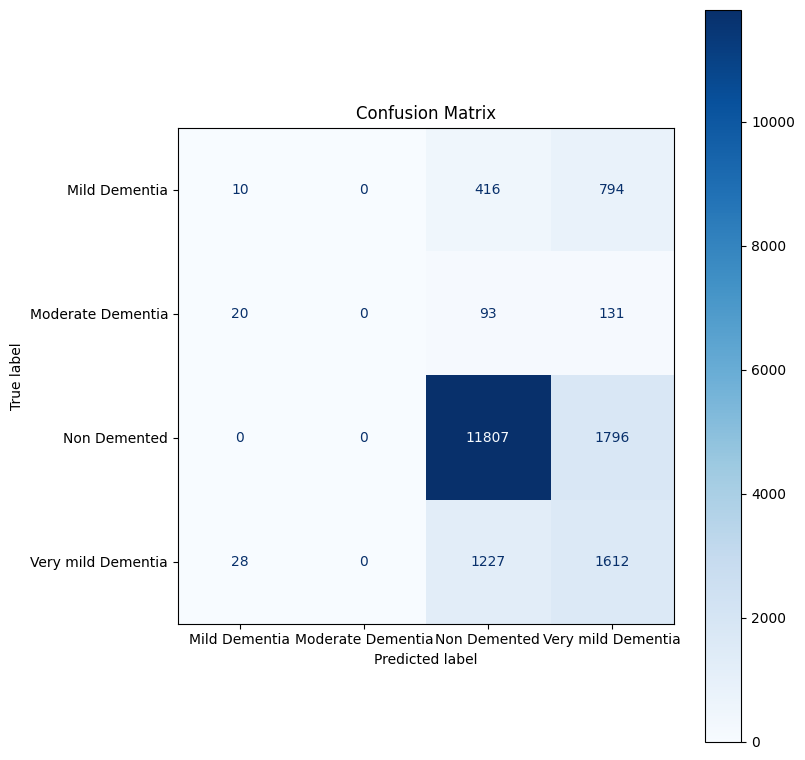

In [93]:
plot_confusion_matrix(vgg16_augment_loaded_y_true,vgg16_augment_loaded_y_pred, class_names)

The "Confusion Matrix" provides an overview of the model’s ability to correctly classify different Alzheimer's disease stages. Key observations include:

1. Class-Specific Performance:
- Mild Dementia:
    - 10 correctly classified cases (very low recall).
    - 416 misclassified as Non-Demented and 794 as Very Mild Dementia, indicating that the model struggles to distinguish this class from early-stage dementia and healthy individuals.
- Moderate Dementia:
    - 20 correctly classified cases.
    - The majority of Moderate Dementia samples are misclassified as Non-Demented (93 cases) or Very Mild Dementia (131 cases).
    - The model finds it difficult to separate this class from other categories.
- Non-Demented:
    - The best-performing class, with 11,807 correctly classified cases.
    - However, 1,796 cases are misclassified as Very Mild Dementia, suggesting some degree of confusion between normal cognitive function and early-stage dementia.
- Very Mild Dementia:
    - 1,612 correctly classified cases, but 1,227 misclassified as Non-Demented, reinforcing the difficulty in detecting early dementia.
    - This overlap suggests that the model struggles to recognize subtle differences between healthy individuals and those with mild cognitive impairment.

2. Misclassification Trends:
- Severe class imbalance bias is evident, as the model strongly favors the Non-Demented class.
- Mild and Moderate Dementia cases are rarely classified correctly, highlighting that the model is ineffective in detecting advanced Alzheimer’s stages.
- Significant confusion exists between Non-Demented and Very Mild Dementia cases, likely due to overlapping features in early disease progression.

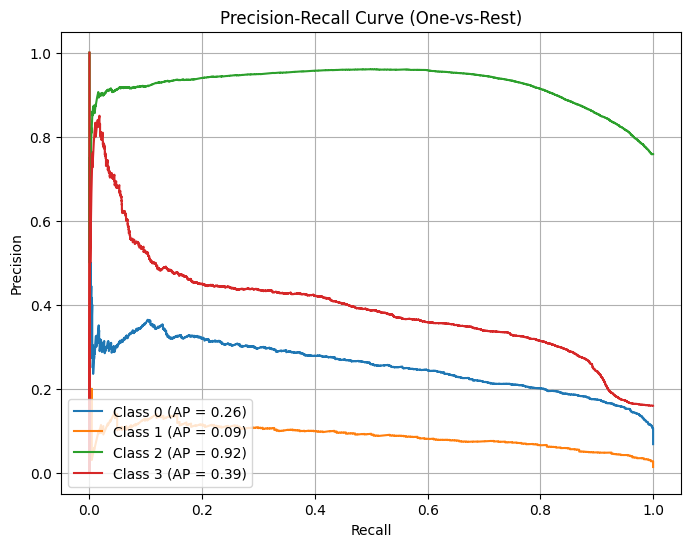

In [94]:
plot_precision_recall_curve(vgg16_augment_loaded_y_true, vgg16_augment_loaded_y_probs)

The "Precision-Recall Curve (One-vs-Rest)" plot provides insights into the model’s ability to correctly classify different Alzheimer's disease stages by balancing precision and recall. Key observations from this graph include:

1. Class-Specific Performance:
- Class 0 (AP = 0.26, Blue Curve):
    - Precision remains low across all recall values, indicating high misclassification rates.
    - The model struggles to maintain precision even at lower recall levels, meaning that predictions for this class are highly unreliable.
- Class 1 (AP = 0.09, Orange Curve):
    - Worst-performing class, with an AP of only 0.09.
    - Precision remains near zero across all recall values, indicating that the model almost never correctly classifies this class.
    - This aligns with the confusion matrix findings, where Moderate Dementia cases were almost entirely misclassified.
- Class 2 (AP = 0.92, Green Curve):
    - Best-performing class, with an AP of 0.92, suggesting high classification confidence.
    - Precision remains above 0.8 across most recall values, meaning that the model is highly confident in detecting this class.
    - However, this dominance suggests dataset imbalance, where the model overfits to this majority class.
- Class 3 (AP = 0.39, Red Curve):
    - Moderate performance, but precision declines as recall increases, indicating some misclassification issues.
    - The model performs better than for Classes 0 and 1 but still remains suboptimal.

2. General Trends:
- Class 2 dominates model predictions, showing high confidence and strong classification ability.
- Class 1 is nearly undetectable (AP = 0.09), confirming that the model completely fails in recognizing Moderate Dementia cases.
- High False Positive Rates:
    - The low AP scores for Classes 0 and 1 indicate that most predictions for these classes are incorrect.
    - This supports previous findings from the confusion matrix, where these cases were frequently misclassified as Non-Demented or Very Mild Dementia.
- Overfitting to the Majority Class (Class 2):
    - The model likely memorizes dominant patterns from the dataset, leading to high precision for Class 2 but poor generalization to other categories.


##  Model 1 - VGG16 Summary on Augmented Data

1. Loss and Accuracy Trends
- Training Loss:
    - The training loss steadily decreases over epochs, indicating that the model is effectively optimizing its parameters on the training dataset.
    - By the final epoch, the training loss is very low (~0.1-0.2), suggesting that the model has minimized errors on the training set.
    - This strong downward trend confirms that the model is successfully fitting the training data.
-  Validation/Test Loss:
    - The validation loss follows an increasing trend, which is a strong indicator of overfitting.
    - Instead of decreasing in parallel with training loss, the validation loss continues to increase throughout training, surpassing 1.4 by the final epoch.
    - This suggests that while the model is performing well on the training data, it struggles to generalize to unseen validation data.
- Training Accuracy:
    - The training accuracy steadily increases, reaching a high value (~0.72), indicating that the model is learning patterns from the training dataset effectively.
    - The continuous improvement without major fluctuations confirms successful optimization.
- Validation/Test Accuracy:
    - Unlike training accuracy, validation accuracy stagnates or slightly declines, remaining significantly lower than training accuracy.
    - By the final epoch, validation accuracy remains below 0.40, reflecting weak generalization to unseen data.
- Overall Trend & Implications:
    - Severe overfitting is evident, as seen in the increasing gap between training and validation loss.
    - The model memorizes training data but fails to generalize, leading to poor validation performance.

2. ROC Curves and AUC Scores
The ROC curve evaluates the model's ability to separate different Alzheimer’s disease stages. The AUC (Area Under the Curve) scores indicate classification performance:
- Class-wise AUC Scores:
    - Class 0 (AUC = 0.86) → Shows good discrimination ability.
    - Class 1 (AUC = 0.90) → Best-performing class, suggesting strong confidence in classification.
    - Class 2 (AUC = 0.84) → Performs well, though slightly lower than Class 0 and Class 1.
    - Class 3 (AUC = 0.77) → The weakest class in terms of discrimination.
- Overall Trend:
    - The model performs significantly better than random guessing (AUC = 0.5).
    - Class 1 has the highest AUC (0.90), meaning the model is highly confident in classifying this stage.
    - Class 3 (AUC = 0.77) is the hardest to classify, showing that some Alzheimer’s disease stages are more difficult to distinguish.
    - The gap between the highest AUC (0.90) and lowest AUC (0.77) suggests inconsistency in the model's ability to classify all categories equally well.

3. Confusion Matrix Analysis
Class-Specific Performance:
- Mild Dementia:
    - Only 10 correct classifications (extremely low recall).
    - Most samples (416) misclassified as Non-Demented, suggesting difficulty distinguishing this stage.
    - 794 cases misclassified as Very Mild Dementia, showing overlap with earlier dementia stages.
- Moderate Dementia:
    - Only 20 correct classifications.
    - Significant misclassification into Non-Demented (93 cases) and Very Mild Dementia (131 cases).
    - Indicates the model struggles to differentiate this class from earlier Alzheimer’s stages.
- Non-Demented (Healthy Patients):
    - Best classification performance (11,807 correctly identified).
    - However, 1,796 cases were misclassified as Very Mild Dementia, showing difficulty in distinguishing between early-stage dementia and healthy individuals.
- Very Mild Dementia:
    - 1,612 correct classifications.
    - 1,227 cases misclassified as Non-Demented, reinforcing the challenge of detecting early-stage Alzheimer’s disease.
- Overall Trend:
    - Severe class imbalance bias is evident—the model heavily favors the Non-Demented class.
    - Poor classification of Mild and Moderate Dementia suggests the model is not learning discriminative features for these conditions.
    - Significant confusion between early dementia and healthy individuals makes early detection of Alzheimer’s difficult.

4. Precision-Recall Curve & AP Scores
Class-Specific Performance:
- Class 0 (AP = 0.26):
    - Low precision across recall values.
    - High misclassification rates suggest weak classification ability.
- Class 1 (AP = 0.09):
    - Worst-performing class, confirming that the model almost never correctly identifies Moderate Dementia cases.
    - This aligns with the confusion matrix, where most of these cases were misclassified.
- Class 2 (AP = 0.92):
    - Best-performing class, with high confidence and precision across recall values.
    - However, this strong performance suggests the model is overfitting to this majority class.
- Class 3 (AP = 0.39):
    - Moderate performance, with precision dropping as recall increases.
    - Better than Classes 0 and 1 but still not ideal.
- Overall Trend:
    - Extreme class imbalance is evident—Class 2 dominates while Class 1 is nearly undetectable.
    - High false positive rates for Classes 0 and 1 indicate that many predictions are incorrect.
    - Overfitting to Class 2 suggests dataset bias, where the model heavily favors this dominant category.



## Model 3 - Efficientnet B4

In [95]:
effnet_b4_aug = initialize_efficientnet_b4()

effnet_b4_aug_loss = nn.CrossEntropyLoss()
effnet_b4_aug_optim = optim.Adam(effnet_b4_aug.parameters(), lr=1e-5)

In [96]:
# Datasets 
train_dataset_augmented_effnet , test_dataset_effnet = create_data_sets(train_data, test_data, train_transform_augmentation_effnet, test_transform_effnetB4)

# DataLoaders
train_loader_augmented_effnet, test_loader_effnet = create_data_loaders(train_dataset_augmented_effnet,test_dataset_effnet,32)


In [97]:
# effnet_b4_augment_trained, effnet_b4_augment_results, effnet_b4_augment_y_true, effnet_b4_augment_y_pred, effnet_b4_augment_y_probs = train_with_validation(effnet_b4_aug, train_loader_augmented_effnet, 
#                                                                                                                                         effnet_b4_aug_loss, effnet_b4_aug_optim, 35, test_loader_effnet) 

In [98]:
# save_model(effnet_b4_augment_trained, effnet_b4_augment_results, effnet_b4_augment_y_true, effnet_b4_augment_y_pred, effnet_b4_augment_y_probs,"effnet_augmented.pth")

In [99]:
effnet_b4_augment_loaded, effnet_b4_augment_loaded_results, effnet_b4_augment_loaded_y_true,effnet_b4_augment_loaded_y_pred, effnet_b4_augment_loaded_y_probs = open_saved_model(model_path_effnet_augment, arch="efficientnet_b4")

Model (efficientnet_b4) and results loaded from /kaggle/input/models/effnet_augmented.pth.


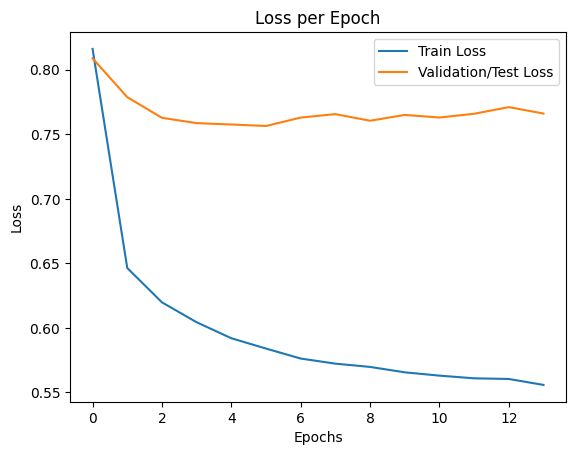

In [100]:
plot_loss(effnet_b4_augment_loaded_results["epochs"], effnet_b4_augment_loaded_results["train_loss"], effnet_b4_augment_loaded_results["val_loss"])

The "Loss per Epoch" plot provides insights into how the model's training and validation loss evolve over multiple epochs. Below are the key observations:

1. Training Loss:
- The training loss decreases steadily over epochs, indicating that the model is effectively learning from the training data.
- At the beginning, the loss is high (~0.81) but drops sharply in the first few epochs.
- As training progresses, the loss continues to decline smoothly, reaching its lowest point (~0.55) in the final epoch.
- This suggests that the model is successfully optimizing and minimizing the error on the training set.

2. Validation/Test Loss:
- The validation loss starts at a similar level to the training loss (~0.81), but unlike the training loss, it does not continue decreasing significantly.
- Instead, after an initial drop, the validation loss stabilizes around 0.75 and even slightly increases in later epochs.
- This pattern suggests that while the model is performing better on training data, it fails to generalize well on the validation dataset.

3. Overall Trend:
- The divergence between training and validation loss suggests overfitting.
- The model is learning patterns in the training data effectively, but its performance on unseen validation data remains stagnant or slightly worsens over time.
- The increase in validation loss after early epochs may indicate that the model starts to memorize training data instead of learning generalizable patterns.



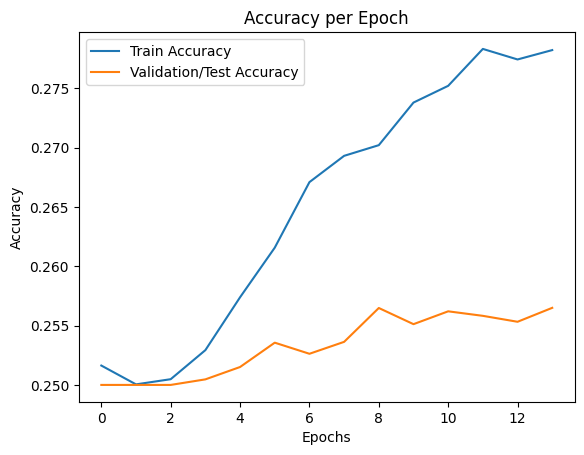

In [101]:
plot_accuracy(effnet_b4_augment_loaded_results["epochs"], effnet_b4_augment_loaded_results["train_accuracy"], effnet_b4_augment_loaded_results["val_accuracy"])

The "Accuracy per Epoch" plot provides an overview of the model's performance during training and validation.

1. Training Accuracy:
- The training accuracy starts at approximately 0.251 and shows a steady increase across epochs.
- As training progresses, the accuracy consistently rises, reaching around 0.278 in the final epochs.
- The smooth and continuous increase indicates that the model is effectively learning patterns in the training data.

2. Validation/Test Accuracy:
- The validation accuracy begins at a similar level (around 0.250) but increases at a much slower rate.
- There is some fluctuation in the validation accuracy, showing minor improvements over epochs but not matching the rapid increase seen in the training accuracy.
- The gap between training and validation accuracy widens over time, indicating potential overfitting.

3. Overall Trend:
- The increasing divergence between training and validation accuracy suggests that while the model performs well on the training data, it struggles to generalize to unseen validation data.
- This pattern could indicate overfitting, where the model memorizes training examples instead of learning generalizable features.


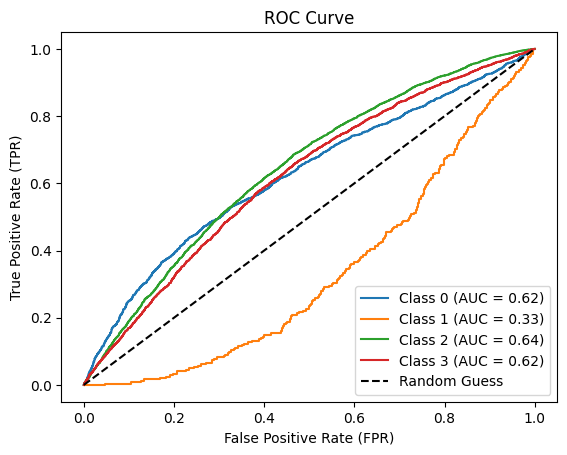

In [102]:
plot_roc_curve(effnet_b4_augment_loaded_y_true, effnet_b4_augment_loaded_y_probs)

The "ROC Curve" plot provides insights into the model's classification performance for each class by evaluating the trade-off between the True Positive Rate (TPR) and the False Positive Rate (FPR).

- Class 0 (AUC = 0.62):
    - The ROC curve for this class is above the diagonal (random guess) line, suggesting that the model performs better than chance.
    - However, an AUC of 0.62 indicates only a modest classification performance.
- Class 1 (AUC = 0.33):
    - This is the weakest performing class, with an AUC well below 0.5, indicating that the model is performing worse than random guessing for this class.
    - The ROC curve for Class 1 lies significantly below the diagonal, suggesting that the model is making incorrect predictions for this class.
- Class 2 (AUC = 0.64):
    - This class has the highest AUC (0.64), showing the best separability among all classes.
    - However, an AUC of 0.64 is still relatively low and suggests a weak overall classification ability.
- Class 3 (AUC = 0.62):
    - Similar to Class 0, this class performs moderately well but is far from ideal.
    - The ROC curve is above the random guess line, but not significantly.
- Overall Trend:
    - The model struggles to differentiate between classes, as seen in the relatively low AUC values.
    - The AUC scores for Classes 0, 2, and 3 (ranging from 0.62 to 0.64) suggest weak but better-than-random classification.
    - The AUC of 0.33 for Class 1 is particularly concerning, indicating severe misclassification issues for this class.


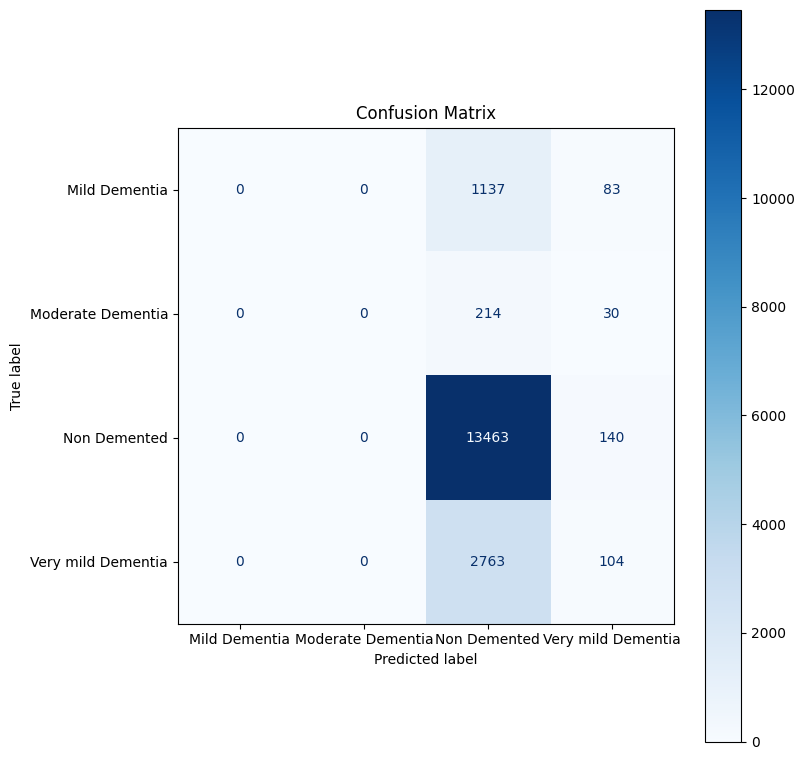

In [103]:
plot_confusion_matrix(effnet_b4_augment_loaded_y_true, effnet_b4_augment_loaded_y_pred, class_names)

The "Confusion Matrix" provides an overview of the model’s ability to classify different stages of Alzheimer's disease. Below are the key observations:

1. Class-Specific Performance:
- Mild Dementia:
    - 0 correctly classified cases → The model completely fails to recognize this class.
    - 1,137 misclassified as Non-Demented and 83 as Very Mild Dementia, indicating that the model does not distinguish Mild Dementia from normal or early-stage cases.
- Moderate Dementia:
    - 0 correctly classified cases → Another critical failure in recognizing this stage.
    - 214 misclassified as Non-Demented and 30 as Very Mild Dementia, further confirming that the model struggles with intermediate dementia stages.
- Non-Demented:
    - 13,463 correctly classified cases → This is the best-performing class.
    - 140 misclassified as Very Mild Dementia, showing that the model sometimes confuses normal cases with early-stage dementia.
- Very Mild Dementia:
    - 2,763 uncorrectly classified cases as Non-Demented
    - 104 correctly 

2. Misclassification Trends:
- Severe Class Imbalance Bias:
    - The model overwhelmingly favors the Non-Demented class, likely due to an imbalance in the dataset.
    - Mild and Moderate Dementia classes have 0 correct predictions, highlighting a severe classification issue.
- Confusion Between Similar Classes:
    - A high number of Mild and Moderate Dementia cases are misclassified as Non-Demented, suggesting that the model fails to detect more advanced Alzheimer's stages.
    - Very Mild Dementia is very often misclassified as Non-Demented, indicating that the model does not capture subtle early-stage symptoms.

3. Overall Trend:
- The model heavily favors Non-Demented predictions, likely because of an imbalanced dataset.
- It fails completely to classify Mild and Moderate Dementia, which is a significant concern for medical applications.
- The overlap between Very Mild Dementia and Non-Demented cases suggests that the model struggles with early detection of Alzheimer’s.

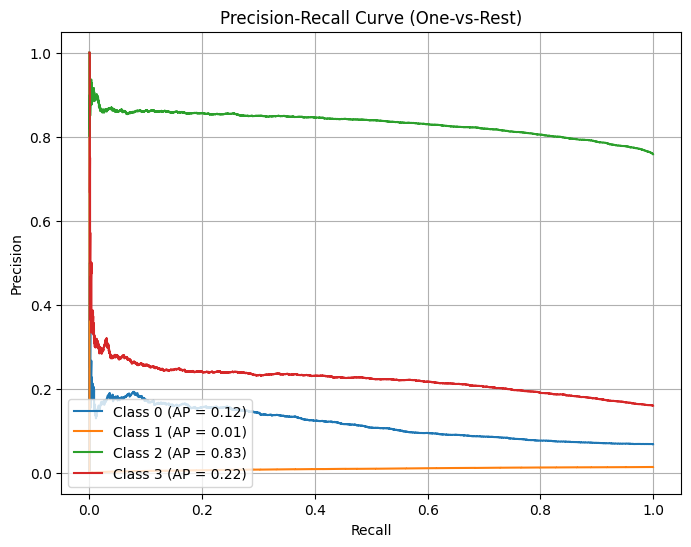

In [104]:
plot_precision_recall_curve(effnet_b4_augment_loaded_y_true, effnet_b4_augment_loaded_y_probs)

The "Precision-Recall Curve (One-vs-Rest)" plot provides insight into the model's performance in terms of precision and recall for each class. Below are the key observations:

1. Class-Specific Performance:
- Class 0 (AP = 0.12):
    - This class exhibits low precision and recall, with an average precision (AP) of only 0.12.
    - The curve shows that the model struggles to balance precision and recall, with precision dropping significantly as recall increases.
    - The low AP suggests that the model is poor at correctly identifying instances of this class.
- Class 1 (AP = 0.01):
    - Extremely poor performance, with AP = 0.01, indicating that the model almost never correctly identifies instances of this class.
    - The curve is close to the x-axis, meaning that precision remains very low across different recall levels.
    - This suggests that the model fails to distinguish this class from others, likely due to class imbalance or poor feature extraction.
- Class 2 (AP = 0.83):
    - This is the best-performing class, with a high AP of 0.83.
    - The curve remains consistently high, showing that the model achieves a good trade-off between precision and recall.
    - This indicates that the model can accurately detect this class with minimal false positives.
- Class 3 (AP = 0.22):
    - The performance for this class is moderate but still weak, with an AP of 0.22.
    -The curve shows a sharp drop in precision at lower recall values, indicating that the model has difficulties classifying this class correctly.

2. Overall Trends:
- The model performs well only for Class 2 (AP = 0.83) but struggles significantly for the other classes.
- Class 1 has almost no predictive power (AP = 0.01), meaning the model completely fails to recognize this class.
- Class 0 and Class 3 have poor precision-recall trade-offs, suggesting that the model is misclassifying instances and lacks confidence in its predictions.
- This indicates severe class imbalance, where the model is biased towards certain classes while ignoring others.

## Model 3 - Efficientnet B4 Summary on Augmented Data

1. Training vs Validation Loss and Accuracy
- Loss per Epoch:
    - The training loss decreases steadily, indicating that the model effectively learns from the training data.
    - However, the validation loss stabilizes early and slightly increases in later epochs, indicating overfitting.
- Accuracy per Epoch:
    - The training accuracy increases significantly over epochs, while validation accuracy improves only slightly.
    - The growing gap between training and validation accuracy confirms that the model memorizes training data rather than learning generalizable patterns.
- Key Issue:
    - Overfitting → The model generalizes poorly to unseen data.

2. ROC Curve Analysis (Class Separability)
- AUC Scores:
    - Class 0: 0.62, Class 2: 0.64, Class 3: 0.62 → Moderate classification performance.
    - Class 1: 0.33 → The model performs worse than random guessing.
    - The low AUC scores suggest that the model struggles to differentiate between classes, with Class 1 being the worst-performing class.
- Key Issue:
    - Poor class separability → The model does not effectively learn distinguishing features between disease stages.

3. Confusion Matrix (Misclassification Patterns)
- Mild Dementia (0 correct classifications) and Moderate Dementia (0 correct classifications) → The model completely fails to detect these categories.
- Non-Demented class is overrepresented (13,463 correct classifications) → The model biases heavily toward the majority class.
- Very Mild Dementia is misclassified as Non-Demented, reinforcing difficulty in detecting early-stage Alzheimer's.
- Key Issues:
    - Severe class imbalance bias → The model predominantly predicts the majority class.
    - Fails to detect critical disease stages (Mild & Moderate Dementia).

4. Precision-Recall Curve (Detection Reliability)
- Class 2 (AP = 0.83) is the only class detected with reasonable reliability.
- Class 1 (AP = 0.01) is nearly undetectable.
- Class 0 (AP = 0.12) and Class 3 (AP = 0.22) have very low precision and recall, indicating that even when the model makes predictions, they are highly unreliable.
- Key Issues:
    - Poor precision and recall for most classes → The model’s predictions are highly uncertain.
    - Class 1 is nearly impossible to classify correctly, making the model ineffective in real-world applications.

## Summary of the Model's Performance on the Unaugmented Dataset

In [105]:
df4 = pd.DataFrame(resnet_augment_loaded_results).mean()
df5 = pd.DataFrame(vgg16_augment_loaded_results).mean()
df6 = pd.DataFrame(effnet_b4_augment_loaded_results).mean()



combined_df2 = pd.DataFrame({
    'Metric': df4.index,  
    'ResNET50_augment': df4.values,
    'VGG16_augment': df5.values,
    'EffNetB4_augment': df6.values,
}).reset_index(drop=True)

combined_df2[::1].style.highlight_max(axis=1,subset=combined_df2.columns[1:])

,Metric,ResNET50_augment,VGG16_augment,EffNetB4_augment
0,epochs,8.000000,2.500000,6.500000
1,train_loss,0.523017,0.255305,0.599011
2,val_loss,0.682794,1.140008,0.767375
3,train_accuracy,0.300720,0.578648,0.265256
4,val_accuracy,0.287402,0.344614,0.253374
5,train_precision,0.431541,0.722238,0.384440
6,val_precision,0.273572,0.332743,0.257408
7,train_recall,0.300720,0.578648,0.265256
8,val_recall,0.287402,0.344614,0.253374
9,train_f1,0.304766,0.599521,0.249847


# Summary of Models' Performance with and without Augmentation

In [106]:
final_combined_df = pd.merge(combined_df, combined_df2, on='Metric')
final_combined_df.style.highlight_max(axis=1, subset=final_combined_df.columns[1:])


,Metric,ResNET50_no_aug,VGG16_no_aug,EffNetB4_no_aug,ResNET50_augment,VGG16_augment,EffNetB4_augment
0,epochs,7.500000,4.000000,14.500000,8.000000,2.500000,6.500000
1,train_loss,0.450919,0.062903,0.536013,0.523017,0.255305,0.599011
2,val_loss,0.609828,1.696665,0.817045,0.682794,1.140008,0.767375
3,train_accuracy,0.373413,0.890638,0.296840,0.300720,0.578648,0.265256
4,val_accuracy,0.317240,0.389855,0.257736,0.287402,0.344614,0.253374
5,train_precision,0.503910,0.940269,0.449963,0.431541,0.722238,0.384440
6,val_precision,0.381970,0.436604,0.275688,0.273572,0.332743,0.257408
7,train_recall,0.373413,0.890638,0.296840,0.300720,0.578648,0.265256
8,val_recall,0.317240,0.389855,0.257736,0.287402,0.344614,0.253374
9,train_f1,0.395047,0.900685,0.302512,0.304766,0.599521,0.249847


# IMPORTANT EXPERIMENTS

The experiments in this project are conducted using only non-augmented MRI data to preserve the anatomical integrity of the scans and avoid introducing artificial distortions. Augmentation, while useful, could introduce variability that complicates model evaluation and comparison with existing studies. Additionally, training on raw data ensures a fair assessment of model performance without additional computational overhead. Future research may explore augmentation, but the current focus is on establishing a strong baseline for analysis.

For simplicity, time efficiency, and to highlight the main trends, the experiments will be conducted using the ResNet50 model.

## Experiment 1 - The Impact of Data Splitting on Model Performance in Alzheimer's MRI Classification

In [107]:
df

,file_path,class,patient_id
0,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,302
1,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,114
2,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,150
3,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,253
4,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,349
...,...,...,...
86432,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,28
86433,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,268
86434,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,137
86435,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,31


In [108]:
train_data_experiment, test_data_experiment = train_test_split(df, test_size=0.2,stratify=df['class'])
# The same data, i added only stratify split

Verify whether images from the same patient appear in multiple splits

In [109]:
check_patient_id_overlap(train_data_experiment,test_data_experiment)

Found 347 overlapping patient_id(s):
{1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 188, 189, 190, 191, 192, 193, 195, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 216, 217, 218, 220, 221, 222, 223, 224, 226, 227, 228, 229, 230, 231, 232, 233

In [110]:
test_data_experiment["class"].value_counts(), train_data_experiment["class"].value_counts()

(class
 Non Demented          13445
 Very mild Dementia     2745
 Mild Dementia          1000
 Moderate Dementia        98
 Name: count, dtype: int64,
 class
 Non Demented          53777
 Very mild Dementia    10980
 Mild Dementia          4002
 Moderate Dementia       390
 Name: count, dtype: int64)

In [111]:
# Dataset and Data Loaders for ResNET and VGG16
train_dataset_exp, test_dataset_exp = create_data_sets(train_data_experiment, test_data_experiment, train_transform_no_augmentation , test_transform )
train_loader_exp, test_loader_exp = create_data_loaders(train_dataset_exp,test_dataset_exp,32)

In [112]:
resnet_exp = initialize_resnet50()

resnet_exp_loss = nn.CrossEntropyLoss()
resnet_exp_optim = optim.Adam(resnet_exp.fc.parameters(), lr=1e-5)  

In [113]:
# resnet_exp_trained, resnet_exp_results, resnet_exp_y_true, resnet_exp_y_pred, resnet_exp_y_probs = train_with_validation(resnet_exp, train_loader_exp, 
#                                                                                                                                         resnet_exp_loss, resnet_exp_optim, 50, 
#                                                                                                                                         test_loader_exp) 

In [114]:
# save_model(resnet_exp_trained, resnet_exp_results, resnet_exp_y_true, resnet_exp_y_pred, resnet_exp_y_probs,"resnet_exp.pth")

In [115]:
resnet_exp_lr_loaded, resnet_exp_lr_loaded_results, resnet_exp_lr_loaded_y_true,resnet_exp_lr_loaded_y_pred,  resnet_exp_lr_loaded_y_probs = open_saved_model(model_path_resnet_exp_lr_4, arch="resnet50")


Model (resnet50) and results loaded from /kaggle/input/models/resnet_exp_lower_lr.pth.


In [116]:
df7 = pd.DataFrame(resnet_exp_lr_loaded_results).mean()

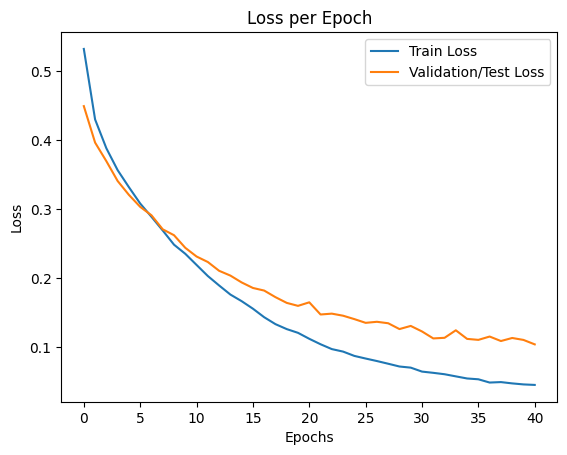

In [117]:
plot_loss(resnet_exp_lr_loaded_results["epochs"], resnet_exp_lr_loaded_results["train_loss"], resnet_exp_lr_loaded_results["val_loss"])

The Loss per Epoch plot illustrates the model's learning process over 40 epochs. Below are the key observations:

Overall Trends:
- Both training loss (blue) and validation loss (orange) decrease consistently, indicating that the model is learning effectively.
- Initially, the losses are relatively high, but they drop sharply during the first 10 epochs, suggesting rapid learning in the early stages.
- After epoch 15, the validation loss stabilizes, while the training loss continues to decrease. This divergence suggests that the model might be overfitting to the training data.
- The validation loss remains low, which could indicate high performance 


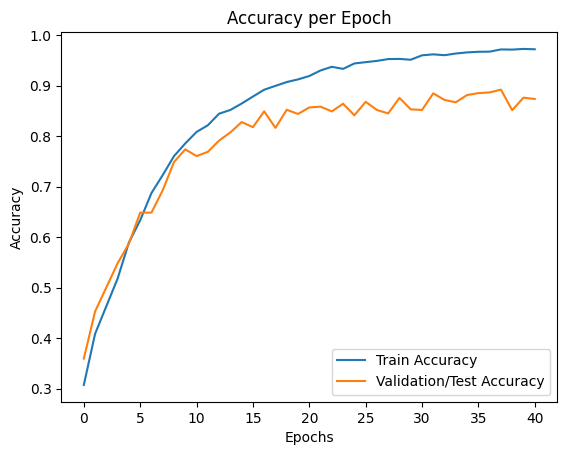

In [118]:
plot_accuracy(resnet_exp_lr_loaded_results["epochs"], resnet_exp_lr_loaded_results["train_accuracy"], resnet_exp_lr_loaded_results["val_accuracy"])


The Accuracy per Epoch plot illustrates the model’s classification performance over 40 epochs. Below are the key observations:

Overall Trends:
- Both training accuracy  and validation accuracy increase rapidly in the first 10 epochs, indicating efficient early learning.
- Around epoch 10, validation accuracy starts to fluctuate, while training accuracy continues to improve steadily.
- By epoch 20, training accuracy surpasses 90%, while validation accuracy stabilizes around 85%.
- A growing gap between training and validation accuracy in later epochs suggests potential overfitting, where the model memorizes the training data rather than generalizing well.


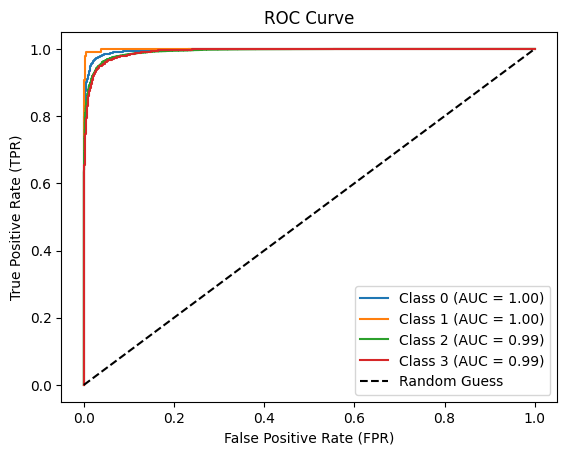

In [119]:
plot_roc_curve(resnet_exp_lr_loaded_y_true,resnet_exp_lr_loaded_y_probs)


The ROC Curve provides insights into the model’s ability to distinguish between different classes. Below are the key observations:

1. Class-Specific Performance:
- Class 0 (AUC = 1.00):
    - The model achieves a perfect AUC score, suggesting that it can separate this class with 100% accuracy.
    - The ROC curve remains close to the top-left corner, indicating an almost ideal classification.
- Class 1 (AUC = 1.00):
    - Similar to Class 0, this class also achieves an AUC of 1.00, which is highly unusual in real-world scenarios.
    - This suggests that the model may be overfitting or benefiting from data leakage.
- Class 2 (AUC = 0.99):
    - The curve remains close to the optimal point, showing that the model classifies this class extremely well.
    - An AUC of 0.99 indicates near-perfect sensitivity and specificity.
- Class 3 (AUC = 0.99):
    - The performance for this class is also exceptionally high, with an AUC of 0.99.
    - The model rarely misclassifies instances of this class.

2. Overall Trends:
- The model achieves near-perfect AUC scores for all classes, which is highly unusual and suggests potential overfitting or data leakage.
- In real-world medical classification tasks, such high AUC values are rarely achievable, especially for complex diagnoses like Alzheimer’s disease.
- These results strongly indicate that the model has likely learned to recognize specific patient features rather than generalizable disease characteristics, which could be a direct consequence of improper data splitting.

This highlights the importance of ensuring a strict patient-level split in medical imaging datasets to obtain realistic model performance estimates.

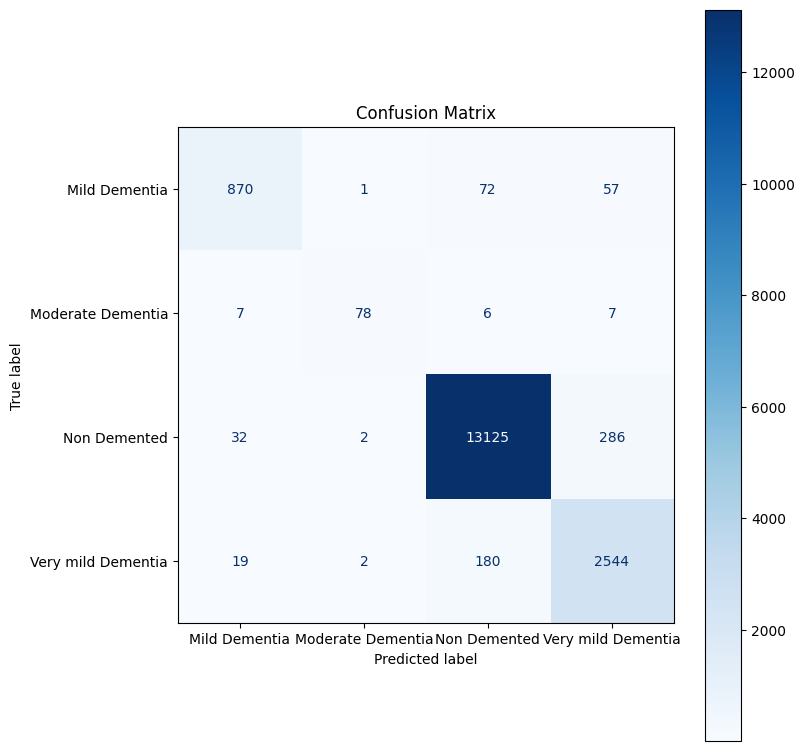

In [120]:
plot_confusion_matrix(resnet_exp_lr_loaded_y_true,resnet_exp_lr_loaded_y_pred,class_names)


The Confusion Matrix provides insight into how well the model classifies each dementia stage. Below are the key observations:

1. Class-Specific Performance:
- Mild Dementia:
    - 870 samples were correctly classified.
    - Some misclassifications occurred, with 72 samples classified as "Non Demented" and 57 as "Very Mild Dementia."
- Moderate Dementia:
    - 78 samples were correctly classified.
    - A few were misclassified as "Mild Dementia" (7) and "Very Mild Dementia" (7), but overall, the model performs reasonably well for this class.
- Non Demented:
    - The largest class, with 13,125 correctly classified instances.
    - However, 286 samples were misclassified as "Very Mild Dementia," indicating some overlap between these categories.
- Very Mild Dementia:
    - 2,544 instances were correctly classified.
    - 180 were confused with "Non Demented," suggesting difficulty in distinguishing very mild cases from healthy individuals.

2. Overall Trends:
- The model performs exceptionally well for the "Non Demented" class, likely due to the high number of training samples in this category.
- Some confusion exists between "Very Mild Dementia" and "Non Demented," indicating that these conditions share similar features, making classification more challenging.
- The model also struggles slightly with "Mild Dementia" and "Moderate Dementia," as these are more difficult to differentiate.

While the confusion matrix suggests strong classification performance, the artificially high accuracy may be a result of improper data splitting, where images from the same patients appear in both the training and validation sets.

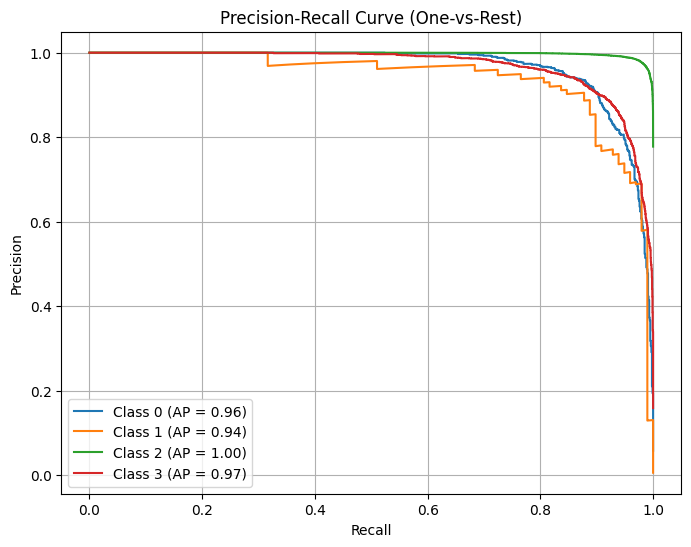

In [121]:
plot_precision_recall_curve(resnet_exp_lr_loaded_y_true, resnet_exp_lr_loaded_y_probs)


The Precision-Recall (PR) curve evaluates the model’s ability to balance precision and recall across different classes. Below are the key observations:

1. Class-Specific Performance:
- Class 0 (AP = 0.96):
    - The model achieves high precision and recall, with an average precision (AP) of 0.96.
    - The curve remains consistently high, suggesting strong classification performance for this class.
- Class 1 (AP = 0.94):
    - Similar to Class 0, this class also has a high AP of 0.94, indicating good precision-recall trade-off.
    - The curve shows only a slight decline, meaning the model can accurately detect instances of this class with few false positives.
- Class 2 (AP = 1.00):
    - The best-performing class, with a perfect AP of 1.00.
    - The curve is nearly flat at the top, meaning the model rarely misclassifies this class.
    - Such high performance is unrealistically good and may indicate overfitting or data leakage.
- Class 3 (AP = 0.97):
    - The model performs well, achieving an AP of 0.97.
    - The curve remains high for most recall values, though there is a slight drop-off at the higher recall range.

2. Overall Trends:
- The exceptionally high AP scores (0.94–1.00) suggest that the model is performing almost perfectly, which is highly unrealistic for a complex medical classification task.
- The PR curves remain consistently high, indicating that the model rarely struggles with precision-recall trade-offs.
- These results strongly suggest that the model is overfitting or benefiting from data leakage, likely due to the improper splitting of patient data between the training and validation sets.

## Summary of the Experiment 1 and Key Findings


In this experiment, I aimed to demonstrate the critical importance of proper data splitting in medical image classification tasks, specifically in Alzheimer's disease detection using MRI scans. In my original approach, I ensured that MRI images from the same patient were not included in both the training and test sets. This approach led to significantly lower model performance, which accurately reflected the real-world difficulty of the classification task.

However, in this experiment, **I deliberately skipped this patient-level split** to observe the impact on model performance. The results show a drastic improvement in accuracy, AUC, and F1-score. At first glance, the model appears highly effective, achieving nearly perfect classification results. However, this improvement is misleading, as the model benefits from data leakage—it learns to recognize individual patients rather than the actual patterns of disease progression.

This comparison highlights a crucial issue in medical deep learning applications: without ensuring that data from the same patient is strictly separated across training and testing, models can achieve artificially high performance that does not generalize to unseen patients. Such an oversight can lead to overly optimistic conclusions about a model’s effectiveness in real-world clinical settings.

This experiment serves as strong evidence that proper data partitioning is not just a best practice but a fundamental requirement for achieving reliable and clinically relevant results in medical AI research.

## Experiment 2 - Binary Classification of Alzheimer's Disease Using MRI with Proper Data Splitting


In [122]:
df

,file_path,class,patient_id
0,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,302
1,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,114
2,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,150
3,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,253
4,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,349
...,...,...,...
86432,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,28
86433,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,268
86434,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,137
86435,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,31


In [123]:
df["class"].unique()

array(['Non Demented', 'Very mild Dementia', 'Moderate Dementia',
       'Mild Dementia'], dtype=object)

In [124]:
binary_df = df.copy()

In [125]:
binary_df['binary_class'] = binary_df['class'].replace({
    'Moderate Dementia': 'Alzheimer',
    'Non Demented': 'No Alzheimer',
    'Mild Dementia': 'Alzheimer',
    'Very mild Dementia': 'Alzheimer'
})

binary_df['binary_class'].value_counts()

binary_class
No Alzheimer    67222
Alzheimer       19215
Name: count, dtype: int64

In [126]:
binary_df

,file_path,class,patient_id,binary_class
0,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,302,No Alzheimer
1,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,114,No Alzheimer
2,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,150,No Alzheimer
3,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,253,No Alzheimer
4,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,349,No Alzheimer
...,...,...,...,...
86432,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,28,Alzheimer
86433,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,268,Alzheimer
86434,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,137,Alzheimer
86435,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,31,Alzheimer


In [127]:
patient_to_gen_cams_and_test_model_binary = binary_df[binary_df["patient_id"]==7]
patient_to_gen_cams_and_test_model_binary

,file_path,class,patient_id,binary_class
1618,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,7,No Alzheimer
2593,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,7,No Alzheimer
3222,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,7,No Alzheimer
3365,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,7,No Alzheimer
3399,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,7,No Alzheimer
...,...,...,...,...
65234,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,7,No Alzheimer
65597,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,7,No Alzheimer
66365,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,7,No Alzheimer
66706,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,7,No Alzheimer


In [128]:
binary_df = binary_df[binary_df['patient_id'] != 7]
binary_df

,file_path,class,patient_id,binary_class
0,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,302,No Alzheimer
1,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,114,No Alzheimer
2,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,150,No Alzheimer
3,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,253,No Alzheimer
4,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented,349,No Alzheimer
...,...,...,...,...
86432,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,28,Alzheimer
86433,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,268,Alzheimer
86434,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,137,Alzheimer
86435,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia,31,Alzheimer


In [129]:
binary_train, binary_test = split_data(binary_df)

In [130]:
check_patient_id_overlap(binary_train, binary_test)

No overlapping patient_ids between the training and testing datasets.


### Custom Dataset 

In [131]:
class AlzheimerDatasetBinary(Dataset):
    def __init__(self, dataframe, transform=None, return_path=False):
        
        self.dataframe = dataframe
        self.transform = transform
        self.return_path = return_path  # Addnig option to return file_path, gives easier aceces to images later
        self.class_mapping = {"No Alzheimer": 0, "Alzheimer": 1}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        file_path = self.dataframe.iloc[idx]['file_path']
        label = self.class_mapping[self.dataframe.iloc[idx]['binary_class']]
        image = Image.open(file_path).convert("RGB") # Creating 3 channels - prepae for ResNET and other pretrained model's architecture
        if self.transform:
            image = self.transform(image)

        if self.return_path:  # Passibility of getting file_path
            return image, label, file_path
        return image, label

In [132]:
def create_data_sets_binary(train_data, test_data, train_transf, test_transform):
    train_dataset = AlzheimerDatasetBinary(train_data, transform=train_transf,return_path=False)
    test_dataset = AlzheimerDatasetBinary(test_data, transform=test_transform,return_path=True)
    return train_dataset, test_dataset

def create_data_loaders_binary(train_data_set, test_data_set, batch):
    train_loader = DataLoader(train_data_set,batch, shuffle=True,num_workers=2)
    test_loader = DataLoader(test_data_set, batch, shuffle=False,num_workers=2)
    return train_loader, test_loader

In [133]:
train_binary_dataset, test_binary_dataset = create_data_sets_binary(binary_train,binary_test,train_transform_no_augmentation ,test_transform )

train_loader_binary, test_loader_binary = create_data_loaders_binary(train_binary_dataset,test_binary_dataset,32)

In [134]:
def initialize_resnet50_binary():
    model = resnet50(weights=ResNet50_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False  

    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),  
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(512, 1)  
    )
     
    for param in model.fc.parameters():
            param.requires_grad = True

    
    return model.to(device)

resnet_bin = initialize_resnet50_binary()
resnet_bin_loss = nn.BCEWithLogitsLoss()
resnet_bin_optim = optim.Adam(resnet_bin.parameters(), lr=1e-5)



In [135]:
accuracy_bi = BinaryAccuracy().to(device)
f1_bi = BinaryF1Score().to(device)
precision_bi = BinaryPrecision().to(device)
recall_bi = BinaryRecall().to(device)
auc_metric_bi = BinaryAUROC().to(device)

val_accuracy_bi = BinaryAccuracy().to(device)
val_f1_bi = BinaryF1Score().to(device)
val_precision_bi = BinaryPrecision().to(device)
val_recall_bi = BinaryRecall().to(device)
val_auc_metric_bi = BinaryAUROC().to(device)

In [136]:
def train_with_validation_binary(model, train_loader, loss_function, optimizer, epochs, val_loader=None):
    model.to(device)
    torch.manual_seed(42)
    
    scheduler = ReduceLROnPlateau(
        optimizer, 
        mode='max',           
        factor=0.1,           
        patience=3,           
        threshold=0.0001,     
        verbose=True
    )
    
    results = {
        "epochs": [],
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": [],
        "train_precision": [],
        "val_precision": [],
        "train_recall": [],
        "val_recall": [],
        "train_f1": [],
        "val_f1": [],
        "train_auc": [],
        "val_auc": [],
        "best_epoch_number": 0
    }

    best_val_f1 = float('-inf')
    best_y_true = []
    best_y_pred = []
    best_y_probs = []


    early_stopping = EarlyStopping(patience=5, verbose=True, path='best_model.pth',delta = 0.001) # Early stopping params, may change later

    
    for epoch in range(epochs):
        model.train()
        

        accuracy_bi.reset()
        f1_bi.reset()
        precision_bi.reset()
        recall_bi.reset()
        auc_metric_bi.reset()

        train_loss_batch = 0

        if val_loader:
            val_accuracy_bi.reset()
            val_f1_bi.reset()
            val_precision_bi.reset()
            val_recall_bi.reset()
            val_auc_metric_bi.reset()
            val_loss_batch = 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device).float().unsqueeze(1)

            preds = model(X)
            loss = loss_function(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_batch += loss.item()
            accuracy_bi.update(preds, y)
            f1_bi.update(preds, y)
            precision_bi.update(preds, y)
            recall_bi.update(preds, y)
            auc_metric_bi.update(preds, y)

        train_loss = train_loss_batch / len(train_loader)
        train_acc = accuracy_bi.compute().item()
        train_precision = precision_bi.compute().item()
        train_recall = recall_bi.compute().item()
        train_f1 = f1_bi.compute().item()
        train_auc = auc_metric_bi.compute().item()

        results["epochs"].append(epoch)
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_acc)
        results["train_precision"].append(train_precision)
        results["train_recall"].append(train_recall)
        results["train_f1"].append(train_f1)
        results["train_auc"].append(train_auc)


        # Validation
        y_true = []
        y_pred = []
        y_probs = []  # Probabilities
        
   
        if val_loader is not None:
            model.eval()
            with torch.inference_mode():
                for X_val, y_val , _ in val_loader:
                    X_val, y_val = X_val.to(device), y_val.to(device).float().unsqueeze(1)
                    predictions = model(X_val)
                    val_loss = loss_function(predictions, y_val)
                    val_loss_batch += val_loss.item()

                    val_accuracy_bi.update(predictions, y_val)
                    val_f1_bi.update(predictions, y_val)
                    val_precision_bi.update(predictions, y_val)
                    val_recall_bi.update(predictions, y_val)
                    val_auc_metric_bi.update(predictions, y_val)

                    y_true.extend(y_val.cpu().tolist())
                    y_pred.extend((torch.sigmoid(predictions) > 0.5).float().cpu().tolist())
                    y_probs.extend(torch.sigmoid(predictions).cpu().tolist())
                     
                 

                val_loss = val_loss_batch / len(val_loader)
                val_acc = val_accuracy_bi.compute().item()
                val_precision_bi_ = val_precision_bi.compute().item()
                val_recall_bi_ = val_recall_bi.compute().item()
                val_f1_bi_ = val_f1_bi.compute().item()
                val_auc_metric_bi_ = val_auc_metric_bi.compute().item()

                results["val_loss"].append(val_loss)
                results["val_accuracy"].append(val_acc)
                results["val_precision"].append(val_precision_bi_)
                results["val_recall"].append(val_recall_bi_)
                results["val_f1"].append(val_f1_bi_)
                results["val_auc"].append(val_auc_metric_bi_)

                scheduler.step(val_f1_bi_) # Learing rate adjustement

                # Save results of best model
                if val_f1_bi_ > best_val_f1:
                    best_val_f1 = val_f1_bi_
                    best_y_true = y_true.copy()
                    best_y_pred = y_pred.copy()
                    best_y_probs = y_probs.copy()
                    results["best_epoch_number"] = epoch

                early_stopping(-val_f1_bi_, model) # This function is written in the way that minimizing is better, but in my case i want to maximzie this value. Thas why i use '-' sign
                if early_stopping.early_stop:                  #https://github.com/Bjarten/early-stopping-pytorch/blob/main/early_stopping_pytorch/early_stopping.py#L28
                    print("Early stopping triggered!")
                    break
        
        if epoch % 2 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}/{epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train AUC: {train_auc:.4f}")
            if  val_loader is not None:
                print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1: {val_f1_bi_:.4f}, Val Precision: {val_precision_bi_:.4f}, Val Recall: {val_recall_bi_:.4f}, Val AUC: {val_auc_metric_bi_:.4f}")
    

    

    
    print("Loading the best model...")
    
    model.load_state_dict(torch.load('best_model.pth', weights_only=True))
   
    

    return model, results, best_y_true, best_y_pred, best_y_probs

### Plots

In [137]:
def plot_roc_curve_binary(y_true, y_probs):
    """
    Plots the ROC curve for a binary classification problem.

    Parameters:
    - y_true: List or array of true labels (0 or 1).
    - y_probs: List or array of predicted probabilities for class 1.

    Generates the ROC curve, calculates AUC, and displays the plot.
    """
    
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', label="Random Guess")  
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve for Binary Classification')
    plt.legend(loc="lower right")
    plt.show()

In [138]:
def plot_confusion_matrix_binary(y_true, y_pred):
    """
    Plots the confusion matrix for binary classification.

    Parameters:
    - y_true: List or array of true labels (0 or 1).
    - y_pred: List or array of predicted labels (0 or 1).

    Displays a confusion matrix.
    """
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Alzheimer", "Alzheimer"])
    
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title("Confusion Matrix")
    plt.show()


In [139]:
def plot_precision_recall_curve_binary(y_true, y_probs):
    """
    Plots the Precision-Recall Curve for binary classification.

    Parameters:
    - y_true: List or array of true labels (0 or 1).
    - y_probs: List or array of predicted probabilities for class 1.

    Displays the Precision-Recall curve.
    """

    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    ap_score = average_precision_score(y_true, y_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall (AP = {ap_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Binary Classification')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()


In [140]:
# resnet_bin, resnet_bin_results, resnet_bin_y_true, resnet_bin_y_pred, resnet_bin_y_probs = train_with_validation_binary(resnet_bin, train_loader_binary, 
#                                                                                                                     resnet_bin_loss, resnet_bin_optim, 40, test_loader_binary) 


In [141]:
# save_model(resnet_bin, resnet_bin_results, resnet_bin_y_true, resnet_bin_y_pred, resnet_bin_y_probs,"resnet_binary.pth")

In [142]:
resnet_binary_loaded, resnet_binary_loaded_results, resnet_binary_loaded_y_true, resnet_binary_loaded_y_pred,  resnet_binary_loaded_y_probs = open_saved_model(model_path_resnet_binary, arch="resnet50",num_classes=1)

Model (resnet50) and results loaded from /kaggle/input/models/resnet_binary.pth.


In [143]:
df8 = pd.DataFrame(resnet_binary_loaded_results).mean()

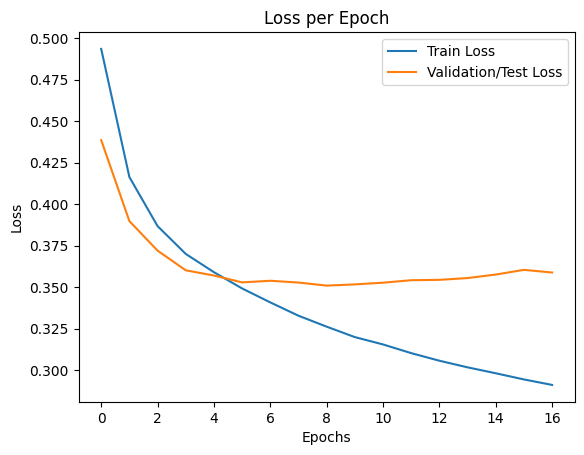

In [144]:
plot_loss(resnet_binary_loaded_results["epochs"], resnet_binary_loaded_results["train_loss"], resnet_binary_loaded_results["val_loss"])

The Loss per Epoch plot illustrates the model’s learning process over 16 epochs. Below are the key observations:

Overall Trends:
- The training loss  decreases steadily throughout the epochs, indicating effective learning.
- The validation loss  initially decreases but starts to plateau around epoch 5, and then slightly increases from epoch 8 onwards.
- This divergence between training and validation loss suggests overfitting, as the model continues to improve on the training data while its performance on validation data remains stagnant or worsens.
- The upward trend in validation loss indicates that the model struggles to generalize beyond the training set, which may suggest that additional regularization techniques (e.g., dropout, weight decay) could be beneficial.

This trend highlights that while the model appears to learn effectively,it does not generalize well to unseen data

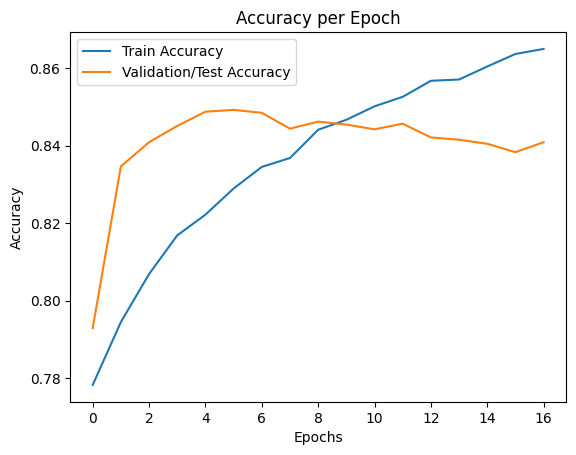

In [145]:
plot_accuracy(resnet_binary_loaded_results["epochs"], resnet_binary_loaded_results["train_accuracy"], resnet_binary_loaded_results["val_accuracy"])

The Accuracy per Epoch plot illustrates the model’s classification performance over 16 epochs. Below are the key observations:

Overall Trends:
- Both training accuracy  and validation accuracy  increase in the early epochs, indicating effective initial learning.
- The validation accuracy rises quickly in the first few epochs and then plateaus around epoch 5, fluctuating slightly between 84% and 85%.
- The training accuracy, however, continues to improve, surpassing the validation accuracy after epoch 8 and reaching over 86% by the end of training.
- The widening gap between training and validation accuracy suggests overfitting, as the model continues to perform better on the training data but does not improve on the validation set.

This trend also indicates that while the model learns well, it may not generalize effectively to unseen data. 

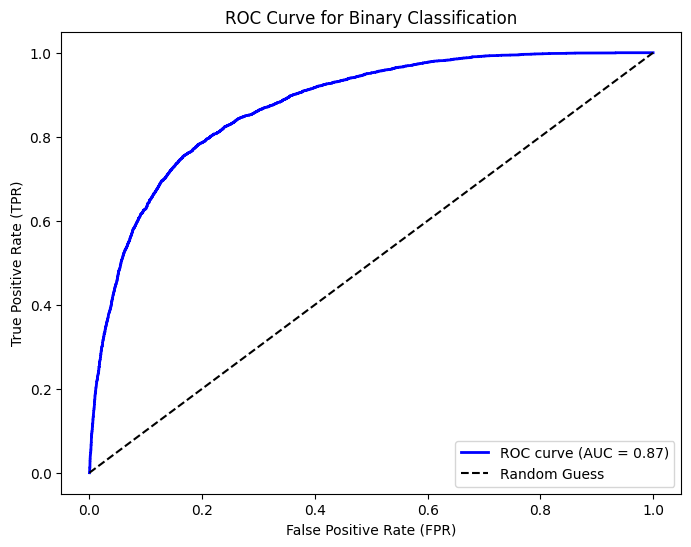

In [146]:
plot_roc_curve_binary(resnet_binary_loaded_y_true, resnet_binary_loaded_y_probs)

The ROC Curve provides insight into the model’s ability to distinguish between the two classes: Alzheimer vs. No Alzheimer. Below are the key observations:

1. Overall Trends:
- The ROC curve (blue) is well above the diagonal random guess line (black), indicating that the model performs significantly better than random classification.
- The Area Under the Curve (AUC) is 0.87, meaning the model has a strong ability to separate positive (Alzheimer) and negative (No Alzheimer) cases.
- The curve has a steep initial rise, suggesting that the model achieves high true positive rates (TPR) at relatively low false positive rates (FPR), which is a desirable characteristic.
- However, as FPR increases beyond 0.4, the TPR gain slows down, indicating that misclassifications increase as the threshold is lowered.

2. Interpretation:
- An AUC of 0.87 indicates that the model has good discriminative power, but it is not perfect.
- The model performs well in distinguishing between Alzheimer and non-Alzheimer cases, though some false positives and false negatives still occur.


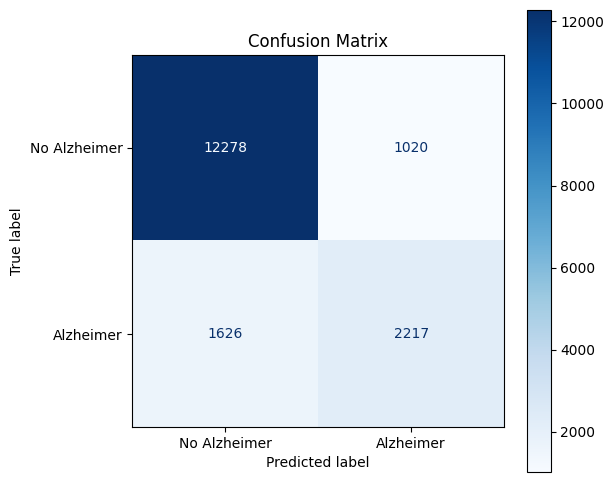

In [147]:
plot_confusion_matrix_binary(resnet_binary_loaded_y_true, resnet_binary_loaded_y_pred)


The Confusion Matrix provides insight into the model’s classification performance for the two classes: Alzheimer vs. No Alzheimer. Below are the key observations:

1. Class-Specific Performance:
- No Alzheimer:
    - 12,278 instances were correctly classified as "No Alzheimer" (True Negatives).
    - 1,020 instances were misclassified as "Alzheimer" (False Positives), meaning the model incorrectly flagged healthy individuals as having the disease.
- Alzheimer:
    - 2,217 instances were correctly classified as "Alzheimer" (True Positives).
    - 1,626 instances were misclassified as "No Alzheimer" (False Negatives), meaning the model failed to detect Alzheimer’s disease in some cases.

2. Overall Trends:
- The model correctly classifies a majority of "No Alzheimer" cases, but struggles more with identifying "Alzheimer" patients, as indicated by the relatively high False Negative Rate (1,626 cases misclassified).
- The False Positive Rate (1,020 cases) is lower than the False Negative Rate, suggesting that the model leans towards conservative predictions (favoring No Alzheimer over Alzheimer diagnoses).

3. Interpretation:
- The model demonstrates strong overall performance, with a high number of correct classifications.
- However, the relatively high number of false negatives (missed Alzheimer cases) could be problematic in clinical applications, as missing a diagnosis is more critical than a false positive.


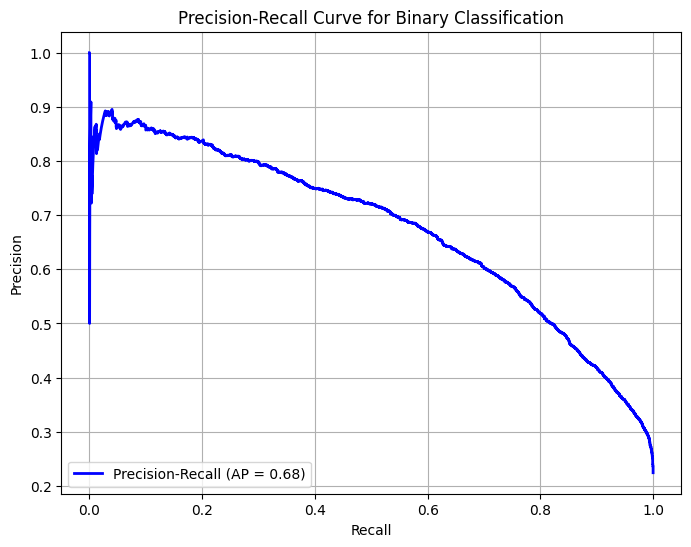

In [148]:
plot_precision_recall_curve_binary(resnet_binary_loaded_y_true,resnet_binary_loaded_y_probs )

The Precision-Recall (PR) curve evaluates the trade-off between precision and recall for the binary classification model (Alzheimer vs. No Alzheimer). Below are the key observations:

1. Overall Trends:
- The average precision (AP) is 0.68, indicating a moderate ability to balance precision and recall.
- The curve starts with high precision (~0.9) at low recall values, meaning the model is very confident in its top-ranked predictions.
- As recall increases, precision gradually declines, indicating that the model struggles to maintain high precision when capturing more positive cases (Alzheimer).
- Around recall = 0.4, the precision drops below 0.75, and it continues to decline towards 0.3 as recall approaches 1.0.
- The initial fluctuations at very low recall values suggest some instability in the predictions for rare cases, which could be due to class imbalance.

2. Interpretation:
- The model performs well for high-confidence predictions, but its ability to detect all Alzheimer cases comes at the cost of lower precision.
- The AP score of 0.68 suggests that while the model is effective, there is room for improvement, particularly in reducing false positives and enhancing sensitivity to positive cases.

This PR curve highlights the importance of optimizing the trade-off between precision and recall in medical applications, where missing a diagnosis (false negative) can have serious consequences.

## Summary of the Experiment 2 and Key Findings

In this experiment, I evaluated the impact of proper patient-level data splitting while transitioning from a four-class classification problem to a binary classification task (Alzheimer vs. No Alzheimer). Unlike the previous experiment, where data leakage inflated the model’s performance, this experiment ensures that images from the same patient do not appear in both training and validation sets.

The results show that while the model achieves a reasonable performance (AUC = 0.87, AP = 0.68), it still struggles with balancing precision and recall, particularly in correctly identifying Alzheimer cases. The confusion matrix reveals a significant number of false negatives (missed Alzheimer cases), which is critical in a real-world diagnostic setting.

This experiment highlights two key insights for my efforts in building a reliable deep learning model for Alzheimer’s diagnosis using MRI:

1. Proper data partitioning is essential to obtain realistic performance estimates and prevent misleadingly high accuracy.
2. Binary classification simplifies the problem, but detecting Alzheimer’s remains challenging due to class imbalance and overlapping features in MRI scans.

# Conclusions
Key Findings:
1. The Impact of Data Augmentation
- Data augmentation had little to no significant impactor worsening results on validation performance.
- It did not lead to a major boost in classification accuracy.
- This suggests that standard augmentation techniques may not be as effective for MRI-based Alzheimer’s classification, possibly due to the nature of medical imaging data.

2. The Effect of Data Leakage (Improper Patient-Level Splitting)
- When the dataset was split without ensuring that images from the same patient were not in multiple splits, validation accuracy reached 78.73% and AUC 0.9823, far exceeding realistic expectations.
- In contrast, with a proper patient-level split, validation accuracy dropped to 31.72% and AUC to 0.8061, demonstrating that data leakage leads to artificially inflated results and does not reflect real-world model performance.
- This experiment reinforces the critical importance of strict patient-level data separation in medical AI research.

3. Binary vs. Multi-Class Classification
- Simplifying the classification problem from four classes (Non Demented, Very Mild Dementia, Mild Dementia, Moderate Dementia) to two classes (Alzheimer vs. No Alzheimer) significantly improved model performance.
- ResNet50 in binary classification achieved:
    - Validation accuracy of 80.45% (compared to 31.72% in multi-class classification).
    - Validation AUC of 0.8714 (compared to 0.8061 in multi-class classification).
- This indicates that binary classification improves model stability and generalization, making it a more effective approach for real-world applications.

4. Lessons Learned & Future Directions
- Patient-level data splitting is crucial for preventing misleadingly high accuracy and ensuring reliable model evaluation.
- Binary classification provides a more robust approach compared to multi-class classification, though it loses granularity in tracking disease progression.
- Data augmentation did not yield significant improvements, suggesting the need for alternative techniques such as domain-specific preprocessing or synthetic data generation.
- Future work could focus on more advanced architectures (e.g., transformers for medical imaging), explainability techniques (Grad-CAM), and clinical validation on external datasets.

This project provides valuable insights into building reliable AI-driven diagnostic tools for Alzheimer’s disease, emphasizing the best practices and challenges in medical deep learning research.

In [149]:
combined_df3 = pd.DataFrame({
    'Metric': df7.index,  
    'ResNet_no_patient-level_split': df7.values,
    'ResNet_binary': df8.values,
}).reset_index(drop=True)

summary_df = pd.merge(final_combined_df , combined_df3, on='Metric')
summary_df.style.highlight_max(axis=1, subset=summary_df.columns[1:])

,Metric,ResNET50_no_aug,VGG16_no_aug,EffNetB4_no_aug,ResNET50_augment,VGG16_augment,EffNetB4_augment,ResNet_no_patient-level_split,ResNet_binary
0,epochs,7.500000,4.000000,14.500000,8.000000,2.500000,6.500000,20.000000,8.000000
1,train_loss,0.450919,0.062903,0.536013,0.523017,0.255305,0.599011,0.158036,0.341803
2,val_loss,0.609828,1.696665,0.817045,0.682794,1.140008,0.767375,0.190827,0.363102
3,train_accuracy,0.373413,0.890638,0.296840,0.300720,0.578648,0.265256,0.844131,0.836154
4,val_accuracy,0.317240,0.389855,0.257736,0.287402,0.344614,0.253374,0.787398,0.840506
5,train_precision,0.503910,0.940269,0.449963,0.431541,0.722238,0.384440,0.903399,0.683183
6,val_precision,0.381970,0.436604,0.275688,0.273572,0.332743,0.257408,0.866548,0.743368
7,train_recall,0.373413,0.890638,0.296840,0.300720,0.578648,0.265256,0.844131,0.468128
8,val_recall,0.317240,0.389855,0.257736,0.287402,0.344614,0.253374,0.787398,0.463073
9,train_f1,0.395047,0.900685,0.302512,0.304766,0.599521,0.249847,0.863212,0.537142
